In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **MAE_Period_1_Vs_Period_2__FT_France**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: FRANCE PERIOD-BASED MAE ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Periods"
output_csv_path = os.path.join(output_dir, "MAE_France_Periods.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading France players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'period': 'int8'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'period'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timestep 5
print("\n🔍 Filtering for timestep 5 only...")
start_filter = time.time()
df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check period distribution
period_counts = df[df['is_predicted'] == 0]['period'].value_counts().sort_index()
print("   • Period distribution (from actual positions):")
for period, count in period_counts.items():
    print(f"     - Period {period}: {count:,} sequences")

# Initialize period error accumulators (FIXED: all dictionaries now include period 2)
period_x_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_y_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_player_counts = {1: 0, 2: 0, 3: 0, 4: 0}

# Calculate errors for each sequence
print(f"\n📊 Processing {unique_sequences:,} sequences for period-based MAE...")
start_processing = time.time()

for seq_id, group in df.groupby('global_sequence_id'):
    # Split into actual and predicted positions
    actual = group[group['is_predicted'] == 0].sort_values(by=['period', 'global_sequence_id'])
    predicted = group[group['is_predicted'] == 1].sort_values(by=['period', 'global_sequence_id'])

    # Verify data integrity
    if len(actual) != 22 or len(predicted) != 22:
        continue

    # Get period (should be consistent for all rows in the sequence)
    period = actual['period'].iloc[0]

    # Calculate errors
    x_errors = np.abs(actual['x'].values - predicted['x'].values)
    y_errors = np.abs(actual['y'].values - predicted['y'].values)

    # Accumulate errors by period
    if period in period_x_errors:
        period_x_errors[period] += np.sum(x_errors)
        period_y_errors[period] += np.sum(y_errors)
        period_player_counts[period] += 22  # 22 players per sequence

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")

# Calculate MAE for each period
mae_period = {}
total_x_errors_all = 0
total_y_errors_all = 0
total_player_count_all = 0

print("\n🧮 Calculating period-based MAE...")
for period in [1, 2, 3, 4]:
    x_errors = period_x_errors.get(period, 0)
    y_errors = period_y_errors.get(period, 0)
    player_count = period_player_counts.get(period, 0)

    total_x_errors_all += x_errors
    total_y_errors_all += y_errors
    total_player_count_all += player_count

    if player_count > 0:
        # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of player predictions)
        mae = (x_errors + y_errors) / (2 * player_count)
        mae_period[period] = mae
        print(f"   • Period {period}:")
        print(f"     - Total Σ|x_errors| = {x_errors:.3f}")
        print(f"     - Total Σ|y_errors| = {y_errors:.3f}")
        print(f"     - Total player predictions = {player_count}")
        print(f"     - MAE = {mae:.6f}")
    else:
        mae_period[period] = 0.0
        print(f"   • Period {period}: No sequences found, MAE = 0.0")

# Calculate MAE for all periods
if total_player_count_all > 0:
    mae_all_periods = (total_x_errors_all + total_y_errors_all) / (2 * total_player_count_all)
else:
    mae_all_periods = 0.0

print(f"\n   • All Periods Combined:")
print(f"     - Total Σ|x_errors| = {total_x_errors_all:.3f}")
print(f"     - Total Σ|y_errors| = {total_y_errors_all:.3f}")
print(f"     - Total player predictions = {total_player_count_all}")
print(f"     - MAE = {mae_all_periods:.6f}")

# Create results dictionary
results = {
    'MAE_period_1': float(mae_period[1]),
    'MAE_period_2': float(mae_period[2]),
    'MAE_period_3': float(mae_period[3]),
    'MAE_period_4': float(mae_period[4]),
    'MAE_all_periods': float(mae_all_periods)
}

# Create results DataFrame
results_df = pd.DataFrame([results], columns=[
    'MAE_period_1', 'MAE_period_2', 'MAE_period_3', 'MAE_period_4', 'MAE_all_periods'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification
print("\n🔍 VERIFICATION:")
print(f"   • MAE_period_1 = {results['MAE_period_1']:.6f}")
print(f"   • MAE_period_2 = {results['MAE_period_2']:.6f}")
print(f"   • MAE_period_3 = {results['MAE_period_3']:.6f}")
print(f"   • MAE_period_4 = {results['MAE_period_4']:.6f}")
print(f"   • MAE_all_periods = {results['MAE_all_periods']:.6f}")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Total player predictions across all periods: {total_player_count_all}")
print(f"   • Total Σ|x_errors| across all periods: {total_x_errors_all:.3f}")
print(f"   • Total Σ|y_errors| across all periods: {total_y_errors_all:.3f}")
print(f"   • Average MAE across all periods: {mae_all_periods:.6f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: France period-based MAE analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: None (this task produces only a single CSV with period-based MAE values)")
print("Note: Using exact MAE formula per specification:")
print("      MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × total number of player predictions)")
print(f"      Output path: {output_dir}")
print("      Note: MAE calculated across all sequences within each period")
print("      Note: First 22 rows = actual positions, next 22 rows = predicted positions per sequence")
print("      Note: Period determined from actual positions (is_predicted=0)")

== STEP 1: FRANCE PERIOD-BASED MAE ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Periods
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Periods/MAE_France_Periods.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Periods

📊 Loading France players CSV with memory optimization...
   ✅ CSV loaded in 0.06 seconds
   ✅ Shape: 23,100 rows, 6 columns
   ✅ Memory usage: 0.33 MB

🔍 Filtering for timestep 5 only...
   ✅ Filtered in 0.00 seconds
   ✅ Remaining rows: 7,700 (timestep 5 only)

🔍 Verifying data structure...
   • Total unique sequ

# **MAE_Period_1_Vs_Period_2__FT_Argentina**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ARGENTINA PERIOD-BASED MAE ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Periods"
output_csv_path = os.path.join(output_dir, "MAE_Argentina_Periods.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Argentina players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'period': 'int8'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'period'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timestep 5
print("\n🔍 Filtering for timestep 5 only...")
start_filter = time.time()
df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check period distribution
period_counts = df[df['is_predicted'] == 0]['period'].value_counts().sort_index()
print("   • Period distribution (from actual positions):")
for period, count in period_counts.items():
    print(f"     - Period {period}: {count:,} sequences")

# Initialize period error accumulators
period_x_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_y_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_player_counts = {1: 0, 2: 0, 3: 0, 4: 0}

# Calculate errors for each sequence
print(f"\n📊 Processing {unique_sequences:,} sequences for period-based MAE...")
start_processing = time.time()

for seq_id, group in df.groupby('global_sequence_id'):
    # Split into actual and predicted positions
    actual = group[group['is_predicted'] == 0].sort_values(by=['period', 'global_sequence_id'])
    predicted = group[group['is_predicted'] == 1].sort_values(by=['period', 'global_sequence_id'])

    # Verify data integrity
    if len(actual) != 22 or len(predicted) != 22:
        continue

    # Get period (should be consistent for all rows in the sequence)
    period = actual['period'].iloc[0]

    # Calculate errors
    x_errors = np.abs(actual['x'].values - predicted['x'].values)
    y_errors = np.abs(actual['y'].values - predicted['y'].values)

    # Accumulate errors by period
    if period in period_x_errors:
        period_x_errors[period] += np.sum(x_errors)
        period_y_errors[period] += np.sum(y_errors)
        period_player_counts[period] += 22  # 22 players per sequence

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")

# Calculate MAE for each period
mae_period = {}
total_x_errors_all = 0
total_y_errors_all = 0
total_player_count_all = 0

print("\n🧮 Calculating period-based MAE...")
for period in [1, 2, 3, 4]:
    x_errors = period_x_errors.get(period, 0)
    y_errors = period_y_errors.get(period, 0)
    player_count = period_player_counts.get(period, 0)

    total_x_errors_all += x_errors
    total_y_errors_all += y_errors
    total_player_count_all += player_count

    if player_count > 0:
        # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of player predictions)
        mae = (x_errors + y_errors) / (2 * player_count)
        mae_period[period] = mae
        print(f"   • Period {period}:")
        print(f"     - Total Σ|x_errors| = {x_errors:.3f}")
        print(f"     - Total Σ|y_errors| = {y_errors:.3f}")
        print(f"     - Total player predictions = {player_count}")
        print(f"     - MAE = {mae:.6f}")
    else:
        mae_period[period] = 0.0
        print(f"   • Period {period}: No sequences found, MAE = 0.0")

# Calculate MAE for all periods
if total_player_count_all > 0:
    mae_all_periods = (total_x_errors_all + total_y_errors_all) / (2 * total_player_count_all)
else:
    mae_all_periods = 0.0

print(f"\n   • All Periods Combined:")
print(f"     - Total Σ|x_errors| = {total_x_errors_all:.3f}")
print(f"     - Total Σ|y_errors| = {total_y_errors_all:.3f}")
print(f"     - Total player predictions = {total_player_count_all}")
print(f"     - MAE = {mae_all_periods:.6f}")

# Create results dictionary
results = {
    'MAE_period_1': float(mae_period[1]),
    'MAE_period_2': float(mae_period[2]),
    'MAE_period_3': float(mae_period[3]),
    'MAE_period_4': float(mae_period[4]),
    'MAE_all_periods': float(mae_all_periods)
}

# Create results DataFrame
results_df = pd.DataFrame([results], columns=[
    'MAE_period_1', 'MAE_period_2', 'MAE_period_3', 'MAE_period_4', 'MAE_all_periods'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification
print("\n🔍 VERIFICATION:")
print(f"   • MAE_period_1 = {results['MAE_period_1']:.6f}")
print(f"   • MAE_period_2 = {results['MAE_period_2']:.6f}")
print(f"   • MAE_period_3 = {results['MAE_period_3']:.6f}")
print(f"   • MAE_period_4 = {results['MAE_period_4']:.6f}")
print(f"   • MAE_all_periods = {results['MAE_all_periods']:.6f}")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Total player predictions across all periods: {total_player_count_all}")
print(f"   • Total Σ|x_errors| across all periods: {total_x_errors_all:.3f}")
print(f"   • Total Σ|y_errors| across all periods: {total_y_errors_all:.3f}")
print(f"   • Average MAE across all periods: {mae_all_periods:.6f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Argentina period-based MAE analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: None (this task produces only a single CSV with period-based MAE values)")
print("Note: Using exact MAE formula per specification:")
print("      MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × total number of player predictions)")
print(f"      Output path: {output_dir}")
print("      Note: MAE calculated across all sequences within each period")
print("      Note: First 22 rows = actual positions, next 22 rows = predicted positions per sequence")
print("      Note: Period determined from actual positions (is_predicted=0)")

== STEP 1: ARGENTINA PERIOD-BASED MAE ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Periods
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Periods/MAE_Argentina_Periods.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Periods

📊 Loading Argentina players CSV with memory optimization...
   ✅ CSV loaded in 0.06 seconds
   ✅ Shape: 13,596 rows, 6 columns
   ✅ Memory usage: 0.19 MB

🔍 Filtering for timestep 5 only...
   ✅ Filtered in 0.00 seconds
   ✅ Remaining rows: 4,532 (timestep 5 only)

🔍 Verifying data structure...
   • Total 

# **MAE_Period_1_Vs_Period_2__FT_Morocco**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: MOROCCO PERIOD-BASED MAE ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Periods"
output_csv_path = os.path.join(output_dir, "MAE_Morocco_Periods.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Morocco players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'period': 'int8'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'period'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timestep 5
print("\n🔍 Filtering for timestep 5 only...")
start_filter = time.time()
df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check period distribution
period_counts = df[df['is_predicted'] == 0]['period'].value_counts().sort_index()
print("   • Period distribution (from actual positions):")
for period, count in period_counts.items():
    print(f"     - Period {period}: {count:,} sequences")

# Initialize period error accumulators
period_x_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_y_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_player_counts = {1: 0, 2: 0, 3: 0, 4: 0}

# Calculate errors for each sequence
print(f"\n📊 Processing {unique_sequences:,} sequences for period-based MAE...")
start_processing = time.time()

for seq_id, group in df.groupby('global_sequence_id'):
    # Split into actual and predicted positions
    actual = group[group['is_predicted'] == 0].sort_values(by=['period', 'global_sequence_id'])
    predicted = group[group['is_predicted'] == 1].sort_values(by=['period', 'global_sequence_id'])

    # Verify data integrity
    if len(actual) != 22 or len(predicted) != 22:
        continue

    # Get period (should be consistent for all rows in the sequence)
    period = actual['period'].iloc[0]

    # Calculate errors
    x_errors = np.abs(actual['x'].values - predicted['x'].values)
    y_errors = np.abs(actual['y'].values - predicted['y'].values)

    # Accumulate errors by period
    if period in period_x_errors:
        period_x_errors[period] += np.sum(x_errors)
        period_y_errors[period] += np.sum(y_errors)
        period_player_counts[period] += 22  # 22 players per sequence

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")

# Calculate MAE for each period
mae_period = {}
total_x_errors_all = 0
total_y_errors_all = 0
total_player_count_all = 0

print("\n🧮 Calculating period-based MAE...")
for period in [1, 2, 3, 4]:
    x_errors = period_x_errors.get(period, 0)
    y_errors = period_y_errors.get(period, 0)
    player_count = period_player_counts.get(period, 0)

    total_x_errors_all += x_errors
    total_y_errors_all += y_errors
    total_player_count_all += player_count

    if player_count > 0:
        # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of player predictions)
        mae = (x_errors + y_errors) / (2 * player_count)
        mae_period[period] = mae
        print(f"   • Period {period}:")
        print(f"     - Total Σ|x_errors| = {x_errors:.3f}")
        print(f"     - Total Σ|y_errors| = {y_errors:.3f}")
        print(f"     - Total player predictions = {player_count}")
        print(f"     - MAE = {mae:.6f}")
    else:
        mae_period[period] = 0.0
        print(f"   • Period {period}: No sequences found, MAE = 0.0")

# Calculate MAE for all periods
if total_player_count_all > 0:
    mae_all_periods = (total_x_errors_all + total_y_errors_all) / (2 * total_player_count_all)
else:
    mae_all_periods = 0.0

print(f"\n   • All Periods Combined:")
print(f"     - Total Σ|x_errors| = {total_x_errors_all:.3f}")
print(f"     - Total Σ|y_errors| = {total_y_errors_all:.3f}")
print(f"     - Total player predictions = {total_player_count_all}")
print(f"     - MAE = {mae_all_periods:.6f}")

# Create results dictionary
results = {
    'MAE_period_1': float(mae_period[1]),
    'MAE_period_2': float(mae_period[2]),
    'MAE_period_3': float(mae_period[3]),
    'MAE_period_4': float(mae_period[4]),
    'MAE_all_periods': float(mae_all_periods)
}

# Create results DataFrame
results_df = pd.DataFrame([results], columns=[
    'MAE_period_1', 'MAE_period_2', 'MAE_period_3', 'MAE_period_4', 'MAE_all_periods'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification
print("\n🔍 VERIFICATION:")
print(f"   • MAE_period_1 = {results['MAE_period_1']:.6f}")
print(f"   • MAE_period_2 = {results['MAE_period_2']:.6f}")
print(f"   • MAE_period_3 = {results['MAE_period_3']:.6f}")
print(f"   • MAE_period_4 = {results['MAE_period_4']:.6f}")
print(f"   • MAE_all_periods = {results['MAE_all_periods']:.6f}")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Total player predictions across all periods: {total_player_count_all}")
print(f"   • Total Σ|x_errors| across all periods: {total_x_errors_all:.3f}")
print(f"   • Total Σ|y_errors| across all periods: {total_y_errors_all:.3f}")
print(f"   • Average MAE across all periods: {mae_all_periods:.6f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Morocco period-based MAE analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: None (this task produces only a single CSV with period-based MAE values)")
print("Note: Using exact MAE formula per specification:")
print("      MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × total number of player predictions)")
print(f"      Output path: {output_dir}")
print("      Note: MAE calculated across all sequences within each period")
print("      Note: First 22 rows = actual positions, next 22 rows = predicted positions per sequence")
print("      Note: Period determined from actual positions (is_predicted=0)")

== STEP 1: MOROCCO PERIOD-BASED MAE ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Periods
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Periods/MAE_Morocco_Periods.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Periods

📊 Loading Morocco players CSV with memory optimization...
   ✅ CSV loaded in 0.95 seconds
   ✅ Shape: 11,220 rows, 6 columns
   ✅ Memory usage: 0.16 MB

🔍 Filtering for timestep 5 only...
   ✅ Filtered in 0.00 seconds
   ✅ Remaining rows: 3,740 (timestep 5 only)

🔍 Verifying data structure...
   • Total unique sequenc

# **MAE_Period_1_Vs_Period_2__FT_Croatia**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: CROATIA PERIOD-BASED MAE ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Periods"
output_csv_path = os.path.join(output_dir, "MAE_Croatia_Periods.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Croatia players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'period': 'int8'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'period'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timestep 5
print("\n🔍 Filtering for timestep 5 only...")
start_filter = time.time()
df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check period distribution
period_counts = df[df['is_predicted'] == 0]['period'].value_counts().sort_index()
print("   • Period distribution (from actual positions):")
for period, count in period_counts.items():
    print(f"     - Period {period}: {count:,} sequences")

# Initialize period error accumulators
period_x_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_y_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_player_counts = {1: 0, 2: 0, 3: 0, 4: 0}

# Calculate errors for each sequence
print(f"\n📊 Processing {unique_sequences:,} sequences for period-based MAE...")
start_processing = time.time()

for seq_id, group in df.groupby('global_sequence_id'):
    # Split into actual and predicted positions
    actual = group[group['is_predicted'] == 0].sort_values(by=['period', 'global_sequence_id'])
    predicted = group[group['is_predicted'] == 1].sort_values(by=['period', 'global_sequence_id'])

    # Verify data integrity
    if len(actual) != 22 or len(predicted) != 22:
        continue

    # Get period (should be consistent for all rows in the sequence)
    period = actual['period'].iloc[0]

    # Calculate errors
    x_errors = np.abs(actual['x'].values - predicted['x'].values)
    y_errors = np.abs(actual['y'].values - predicted['y'].values)

    # Accumulate errors by period
    if period in period_x_errors:
        period_x_errors[period] += np.sum(x_errors)
        period_y_errors[period] += np.sum(y_errors)
        period_player_counts[period] += 22  # 22 players per sequence

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")

# Calculate MAE for each period
mae_period = {}
total_x_errors_all = 0
total_y_errors_all = 0
total_player_count_all = 0

print("\n🧮 Calculating period-based MAE...")
for period in [1, 2, 3, 4]:
    x_errors = period_x_errors.get(period, 0)
    y_errors = period_y_errors.get(period, 0)
    player_count = period_player_counts.get(period, 0)

    total_x_errors_all += x_errors
    total_y_errors_all += y_errors
    total_player_count_all += player_count

    if player_count > 0:
        # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of player predictions)
        mae = (x_errors + y_errors) / (2 * player_count)
        mae_period[period] = mae
        print(f"   • Period {period}:")
        print(f"     - Total Σ|x_errors| = {x_errors:.3f}")
        print(f"     - Total Σ|y_errors| = {y_errors:.3f}")
        print(f"     - Total player predictions = {player_count}")
        print(f"     - MAE = {mae:.6f}")
    else:
        mae_period[period] = 0.0
        print(f"   • Period {period}: No sequences found, MAE = 0.0")

# Calculate MAE for all periods
if total_player_count_all > 0:
    mae_all_periods = (total_x_errors_all + total_y_errors_all) / (2 * total_player_count_all)
else:
    mae_all_periods = 0.0

print(f"\n   • All Periods Combined:")
print(f"     - Total Σ|x_errors| = {total_x_errors_all:.3f}")
print(f"     - Total Σ|y_errors| = {total_y_errors_all:.3f}")
print(f"     - Total player predictions = {total_player_count_all}")
print(f"     - MAE = {mae_all_periods:.6f}")

# Create results dictionary
results = {
    'MAE_period_1': float(mae_period[1]),
    'MAE_period_2': float(mae_period[2]),
    'MAE_period_3': float(mae_period[3]),
    'MAE_period_4': float(mae_period[4]),
    'MAE_all_periods': float(mae_all_periods)
}

# Create results DataFrame
results_df = pd.DataFrame([results], columns=[
    'MAE_period_1', 'MAE_period_2', 'MAE_period_3', 'MAE_period_4', 'MAE_all_periods'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification
print("\n🔍 VERIFICATION:")
print(f"   • MAE_period_1 = {results['MAE_period_1']:.6f}")
print(f"   • MAE_period_2 = {results['MAE_period_2']:.6f}")
print(f"   • MAE_period_3 = {results['MAE_period_3']:.6f}")
print(f"   • MAE_period_4 = {results['MAE_period_4']:.6f}")
print(f"   • MAE_all_periods = {results['MAE_all_periods']:.6f}")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Total player predictions across all periods: {total_player_count_all}")
print(f"   • Total Σ|x_errors| across all periods: {total_x_errors_all:.3f}")
print(f"   • Total Σ|y_errors| across all periods: {total_y_errors_all:.3f}")
print(f"   • Average MAE across all periods: {mae_all_periods:.6f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Croatia period-based MAE analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: None (this task produces only a single CSV with period-based MAE values)")
print("Note: Using exact MAE formula per specification:")
print("      MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × total number of player predictions)")
print(f"      Output path: {output_dir}")
print("      Note: MAE calculated across all sequences within each period")
print("      Note: First 22 rows = actual positions, next 22 rows = predicted positions per sequence")
print("      Note: Period determined from actual positions (is_predicted=0)")

== STEP 1: CROATIA PERIOD-BASED MAE ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Periods
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Periods/MAE_Croatia_Periods.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Periods

📊 Loading Croatia players CSV with memory optimization...
   ✅ CSV loaded in 1.02 seconds
   ✅ Shape: 21,516 rows, 6 columns
   ✅ Memory usage: 0.31 MB

🔍 Filtering for timestep 5 only...
   ✅ Filtered in 0.01 seconds
   ✅ Remaining rows: 7,172 (timestep 5 only)

🔍 Verifying data structure...
   • Total unique sequenc

# **MAE_Period_1_Vs_Period_2__FT_England**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ENGLAND PERIOD-BASED MAE ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Periods"
output_csv_path = os.path.join(output_dir, "MAE_England_Periods.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading England players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'period': 'int8'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'period'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timestep 5
print("\n🔍 Filtering for timestep 5 only...")
start_filter = time.time()
df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check period distribution
period_counts = df[df['is_predicted'] == 0]['period'].value_counts().sort_index()
print("   • Period distribution (from actual positions):")
for period, count in period_counts.items():
    print(f"     - Period {period}: {count:,} sequences")

# Initialize period error accumulators
period_x_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_y_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_player_counts = {1: 0, 2: 0, 3: 0, 4: 0}

# Calculate errors for each sequence
print(f"\n📊 Processing {unique_sequences:,} sequences for period-based MAE...")
start_processing = time.time()

for seq_id, group in df.groupby('global_sequence_id'):
    # Split into actual and predicted positions
    actual = group[group['is_predicted'] == 0].sort_values(by=['period', 'global_sequence_id'])
    predicted = group[group['is_predicted'] == 1].sort_values(by=['period', 'global_sequence_id'])

    # Verify data integrity
    if len(actual) != 22 or len(predicted) != 22:
        continue

    # Get period (should be consistent for all rows in the sequence)
    period = actual['period'].iloc[0]

    # Calculate errors
    x_errors = np.abs(actual['x'].values - predicted['x'].values)
    y_errors = np.abs(actual['y'].values - predicted['y'].values)

    # Accumulate errors by period
    if period in period_x_errors:
        period_x_errors[period] += np.sum(x_errors)
        period_y_errors[period] += np.sum(y_errors)
        period_player_counts[period] += 22  # 22 players per sequence

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")

# Calculate MAE for each period
mae_period = {}
total_x_errors_all = 0
total_y_errors_all = 0
total_player_count_all = 0

print("\n🧮 Calculating period-based MAE...")
for period in [1, 2, 3, 4]:
    x_errors = period_x_errors.get(period, 0)
    y_errors = period_y_errors.get(period, 0)
    player_count = period_player_counts.get(period, 0)

    total_x_errors_all += x_errors
    total_y_errors_all += y_errors
    total_player_count_all += player_count

    if player_count > 0:
        # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of player predictions)
        mae = (x_errors + y_errors) / (2 * player_count)
        mae_period[period] = mae
        print(f"   • Period {period}:")
        print(f"     - Total Σ|x_errors| = {x_errors:.3f}")
        print(f"     - Total Σ|y_errors| = {y_errors:.3f}")
        print(f"     - Total player predictions = {player_count}")
        print(f"     - MAE = {mae:.6f}")
    else:
        mae_period[period] = 0.0
        print(f"   • Period {period}: No sequences found, MAE = 0.0")

# Calculate MAE for all periods
if total_player_count_all > 0:
    mae_all_periods = (total_x_errors_all + total_y_errors_all) / (2 * total_player_count_all)
else:
    mae_all_periods = 0.0

print(f"\n   • All Periods Combined:")
print(f"     - Total Σ|x_errors| = {total_x_errors_all:.3f}")
print(f"     - Total Σ|y_errors| = {total_y_errors_all:.3f}")
print(f"     - Total player predictions = {total_player_count_all}")
print(f"     - MAE = {mae_all_periods:.6f}")

# Create results dictionary
results = {
    'MAE_period_1': float(mae_period[1]),
    'MAE_period_2': float(mae_period[2]),
    'MAE_period_3': float(mae_period[3]),
    'MAE_period_4': float(mae_period[4]),
    'MAE_all_periods': float(mae_all_periods)
}

# Create results DataFrame
results_df = pd.DataFrame([results], columns=[
    'MAE_period_1', 'MAE_period_2', 'MAE_period_3', 'MAE_period_4', 'MAE_all_periods'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification
print("\n🔍 VERIFICATION:")
print(f"   • MAE_period_1 = {results['MAE_period_1']:.6f}")
print(f"   • MAE_period_2 = {results['MAE_period_2']:.6f}")
print(f"   • MAE_period_3 = {results['MAE_period_3']:.6f}")
print(f"   • MAE_period_4 = {results['MAE_period_4']:.6f}")
print(f"   • MAE_all_periods = {results['MAE_all_periods']:.6f}")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Total player predictions across all periods: {total_player_count_all}")
print(f"   • Total Σ|x_errors| across all periods: {total_x_errors_all:.3f}")
print(f"   • Total Σ|y_errors| across all periods: {total_y_errors_all:.3f}")
print(f"   • Average MAE across all periods: {mae_all_periods:.6f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: England period-based MAE analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: None (this task produces only a single CSV with period-based MAE values)")
print("Note: Using exact MAE formula per specification:")
print("      MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × total number of player predictions)")
print(f"      Output path: {output_dir}")
print("      Note: MAE calculated across all sequences within each period")
print("      Note: First 22 rows = actual positions, next 22 rows = predicted positions per sequence")
print("      Note: Period determined from actual positions (is_predicted=0)")

== STEP 1: ENGLAND PERIOD-BASED MAE ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Periods
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Periods/MAE_England_Periods.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Periods

📊 Loading England players CSV with memory optimization...
   ✅ CSV loaded in 1.27 seconds
   ✅ Shape: 19,668 rows, 6 columns
   ✅ Memory usage: 0.28 MB

🔍 Filtering for timestep 5 only...
   ✅ Filtered in 0.01 seconds
   ✅ Remaining rows: 6,556 (timestep 5 only)

🔍 Verifying data structure...
   • Total unique sequenc

# **MAE_Period_1_Vs_Period_2__Baseline_Model**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: BASELINE PERIOD-BASED MAE ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Periods"
output_csv_path = os.path.join(output_dir, "MAE_Baseline_Periods.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Baseline players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'period': 'int8'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'period'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timestep 5
print("\n🔍 Filtering for timestep 5 only...")
start_filter = time.time()
df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check period distribution
period_counts = df[df['is_predicted'] == 0]['period'].value_counts().sort_index()
print("   • Period distribution (from actual positions):")
for period, count in period_counts.items():
    print(f"     - Period {period}: {count:,} sequences")

# Initialize period error accumulators
period_x_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_y_errors = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
period_player_counts = {1: 0, 2: 0, 3: 0, 4: 0}

# Calculate errors for each sequence
print(f"\n📊 Processing {unique_sequences:,} sequences for period-based MAE...")
start_processing = time.time()

for seq_id, group in df.groupby('global_sequence_id'):
    # Split into actual and predicted positions
    actual = group[group['is_predicted'] == 0].sort_values(by=['period', 'global_sequence_id'])
    predicted = group[group['is_predicted'] == 1].sort_values(by=['period', 'global_sequence_id'])

    # Verify data integrity
    if len(actual) != 22 or len(predicted) != 22:
        continue

    # Get period (should be consistent for all rows in the sequence)
    period = actual['period'].iloc[0]

    # Calculate errors
    x_errors = np.abs(actual['x'].values - predicted['x'].values)
    y_errors = np.abs(actual['y'].values - predicted['y'].values)

    # Accumulate errors by period
    if period in period_x_errors:
        period_x_errors[period] += np.sum(x_errors)
        period_y_errors[period] += np.sum(y_errors)
        period_player_counts[period] += 22  # 22 players per sequence

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")

# Calculate MAE for each period
mae_period = {}
total_x_errors_all = 0
total_y_errors_all = 0
total_player_count_all = 0

print("\n🧮 Calculating period-based MAE...")
for period in [1, 2, 3, 4]:
    x_errors = period_x_errors.get(period, 0)
    y_errors = period_y_errors.get(period, 0)
    player_count = period_player_counts.get(period, 0)

    total_x_errors_all += x_errors
    total_y_errors_all += y_errors
    total_player_count_all += player_count

    if player_count > 0:
        # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of player predictions)
        mae = (x_errors + y_errors) / (2 * player_count)
        mae_period[period] = mae
        print(f"   • Period {period}:")
        print(f"     - Total Σ|x_errors| = {x_errors:.3f}")
        print(f"     - Total Σ|y_errors| = {y_errors:.3f}")
        print(f"     - Total player predictions = {player_count}")
        print(f"     - MAE = {mae:.6f}")
    else:
        mae_period[period] = 0.0
        print(f"   • Period {period}: No sequences found, MAE = 0.0")

# Calculate MAE for all periods
if total_player_count_all > 0:
    mae_all_periods = (total_x_errors_all + total_y_errors_all) / (2 * total_player_count_all)
else:
    mae_all_periods = 0.0

print(f"\n   • All Periods Combined:")
print(f"     - Total Σ|x_errors| = {total_x_errors_all:.3f}")
print(f"     - Total Σ|y_errors| = {total_y_errors_all:.3f}")
print(f"     - Total player predictions = {total_player_count_all}")
print(f"     - MAE = {mae_all_periods:.6f}")

# Create results dictionary
results = {
    'MAE_period_1': float(mae_period[1]),
    'MAE_period_2': float(mae_period[2]),
    'MAE_period_3': float(mae_period[3]),
    'MAE_period_4': float(mae_period[4]),
    'MAE_all_periods': float(mae_all_periods)
}

# Create results DataFrame
results_df = pd.DataFrame([results], columns=[
    'MAE_period_1', 'MAE_period_2', 'MAE_period_3', 'MAE_period_4', 'MAE_all_periods'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification
print("\n🔍 VERIFICATION:")
print(f"   • MAE_period_1 = {results['MAE_period_1']:.6f}")
print(f"   • MAE_period_2 = {results['MAE_period_2']:.6f}")
print(f"   • MAE_period_3 = {results['MAE_period_3']:.6f}")
print(f"   • MAE_period_4 = {results['MAE_period_4']:.6f}")
print(f"   • MAE_all_periods = {results['MAE_all_periods']:.6f}")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Total player predictions across all periods: {total_player_count_all}")
print(f"   • Total Σ|x_errors| across all periods: {total_x_errors_all:.3f}")
print(f"   • Total Σ|y_errors| across all periods: {total_y_errors_all:.3f}")
print(f"   • Average MAE across all periods: {mae_all_periods:.6f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Baseline period-based MAE analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: None (this task produces only a single CSV with period-based MAE values)")
print("Note: Using exact MAE formula per specification:")
print("      MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × total number of player predictions)")
print(f"      Output path: {output_dir}")
print("      Note: MAE calculated across all sequences within each period")
print("      Note: First 22 rows = actual positions, next 22 rows = predicted positions per sequence")
print("      Note: Period determined from actual positions (is_predicted=0)")

== STEP 1: BASELINE PERIOD-BASED MAE ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Periods
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Periods/MAE_Baseline_Periods.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Periods

📊 Loading Baseline players CSV with memory optimization...
   ✅ CSV loaded in 2.05 seconds
   ✅ Shape: 198,528 ro

# **MAE_Periods_Comparison_Figure**

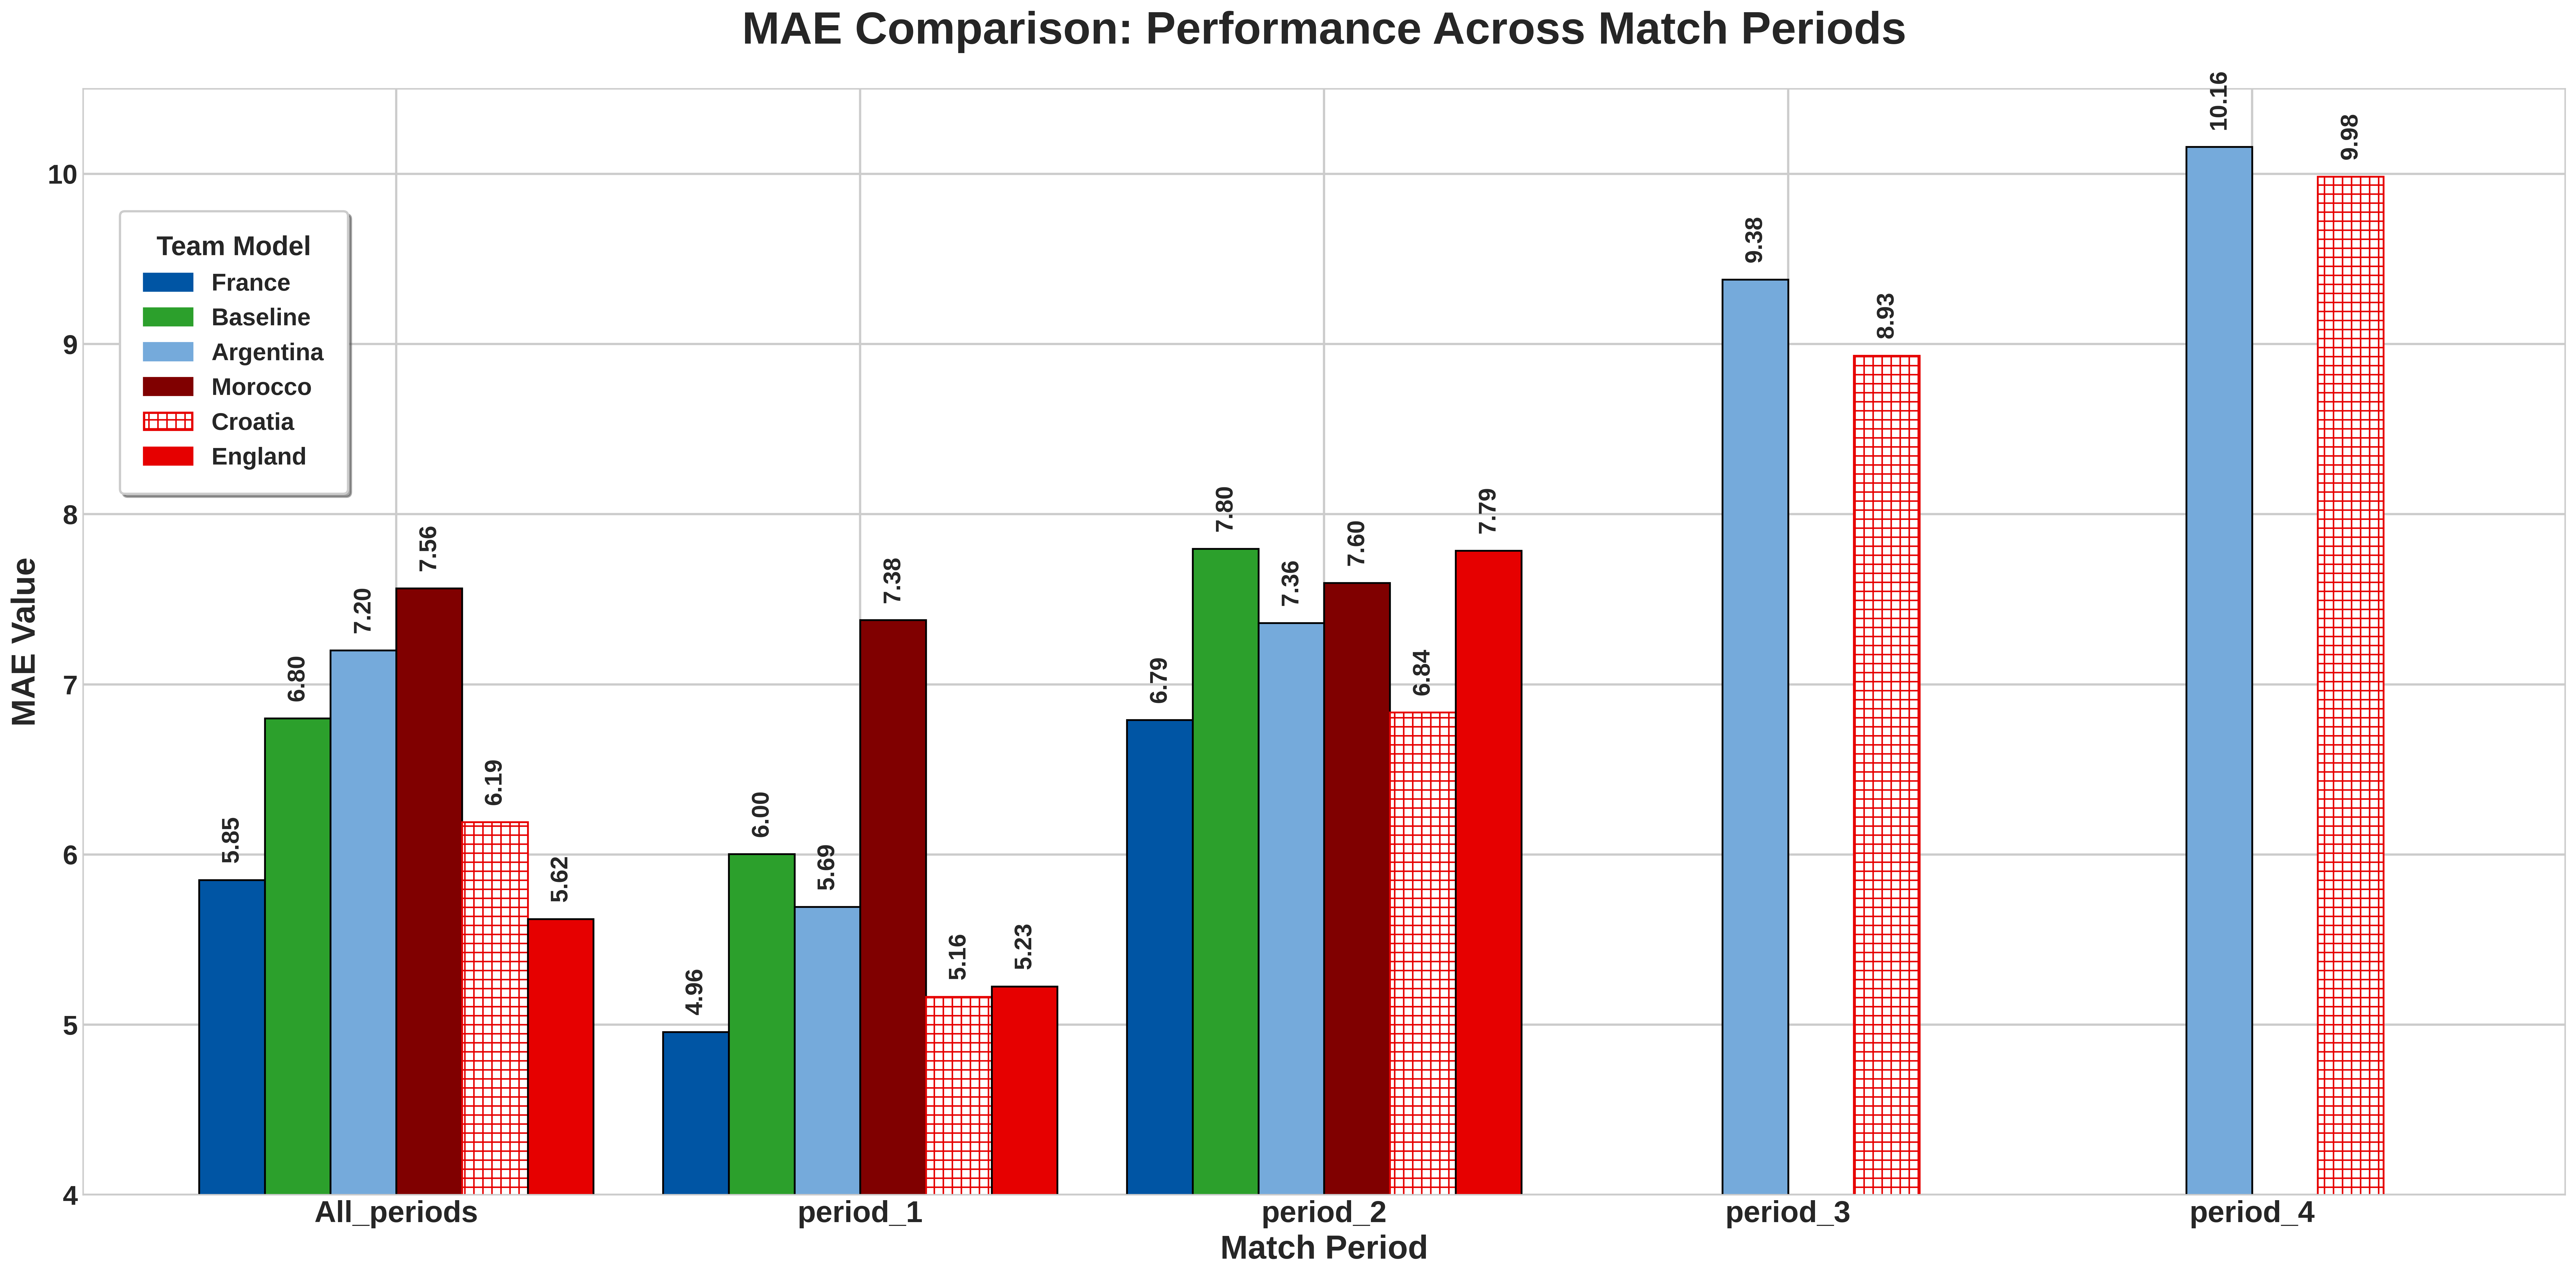

In [ ]:
# @title 📊 Team Performance (Outlier Removed & Optimized Y-Axis)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# 1. SETUP DISPLAY
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 14

# 2. DATA PREPARATION
data = {
    'Period': ['All_periods', 'period_1', 'period_2', 'period_3', 'period_4'],

    # --- KEY CHANGE: Removed the 12.35 outlier (set to np.nan) ---
    'France':    [5.849821, 4.956677, 6.791438, np.nan, np.nan],
    'Baseline':  [6.80, 6.00243, 7.796574, np.nan, np.nan],
    'Argentina': [7.199663, 5.691913, 7.360203, 9.378449, 10.159285],
    'Morocco':   [7.564908, 7.377602, 7.595698, np.nan, np.nan],
    'Croatia':   [6.190639, 5.164827, 6.836007, 8.931721, 9.983871],
    'England':   [5.620522, 5.225306, 7.785617, np.nan, np.nan]
}

df = pd.DataFrame(data)
df = df.set_index('Period')

# 3. COLORS
colors = {
    'Baseline': '#2ca02c',   # Green
    'France': '#0055A4',     # Royal Blue
    'Argentina': '#75AADB',  # Sky Blue
    'Morocco': '#800000',    # Deep Maroon
    'Croatia': '#FFFFFF',    # White Base (Red checks added later)
    'England': '#E60000'     # Standard Red
}
color_list = [colors[col] for col in df.columns]

# 4. PLOTTING
fig, ax = plt.subplots(figsize=(24, 12), dpi=200)

# Plotting
df.plot(kind='bar', ax=ax, color=color_list, width=0.85, edgecolor='black', linewidth=1.2)

# 5. APPLY PATTERNS & ADD LABELS
teams = df.columns.tolist()

for i, bar in enumerate(ax.patches):
    team_index = i // len(df.index)
    team_name = teams[team_index]

    # Add Data Label
    height = bar.get_height()
    if not np.isnan(height) and height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.1,
            f'{height:.2f}',
            ha='center', va='bottom',
            fontsize=16,
            fontweight='bold',
            rotation=90
        )

    # Apply Pattern if Team is Croatia
    if team_name == 'Croatia':
        bar.set_hatch('++')
        bar.set_edgecolor('#E60000')

# 6. LEGEND CONFIGURATION
legend_handles = []
for team in teams:
    if team == 'Croatia':
        handle = mpatches.Patch(facecolor='white', edgecolor='#E60000', hatch='++', label=team)
    else:
        handle = mpatches.Patch(color=colors[team], label=team)
    legend_handles.append(handle)

# Placed in the top left, in the empty space above the shorter bars
ax.legend(
    handles=legend_handles,
    title='Team Model',
    title_fontsize=18,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.90), # Positioned roughly at Y=9.5
    ncol=1,
    frameon=True,
    fancybox=True,
    shadow=True,
    facecolor='white',
    fontsize=16,
    borderpad=1
)

# 7. TITLES & FORMATTING
ax.set_title('MAE Comparison: Performance Across Match Periods', fontsize=30, fontweight='bold', pad=30)
ax.set_ylabel('MAE Value', fontsize=22, fontweight='bold')
ax.set_xlabel('Match Period', fontsize=22, fontweight='bold')

plt.xticks(rotation=0, fontsize=20, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# --- KEY CHANGE: Y-Axis Reduced to 10.5 ---
# With the 12.35 outlier gone, we can zoom in much more.
ax.set_ylim(4, 10.5)

plt.tight_layout()
plt.show()

# **MAE_Players_Movements_T4_T5_FT_France**

## **Tested_on_Frnace**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE"
output_csv_path = os.path.join(output_dir, "MAE_France_Player_Movement_vs_MAE.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading France players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete data: {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: France player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for France player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/MAE_France_Player_Movement_vs_MAE.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE

📊 Loading France players CSV with memory optimization...
   ✅ CSV loaded in 0.06 seconds
   ✅ Shape: 23,100 rows, 5 columns
   ✅ Memory usage: 0.31 MB

🔍 Filtering for timesteps 4 and 5 only...
   ✅ Filtered in

== STEP 2: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/MAE_France_Player_Movement_vs_MAE.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/France_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE

📊 Loading France sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 175 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 2.46 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/France_Player_Movement_vs_MAE.p

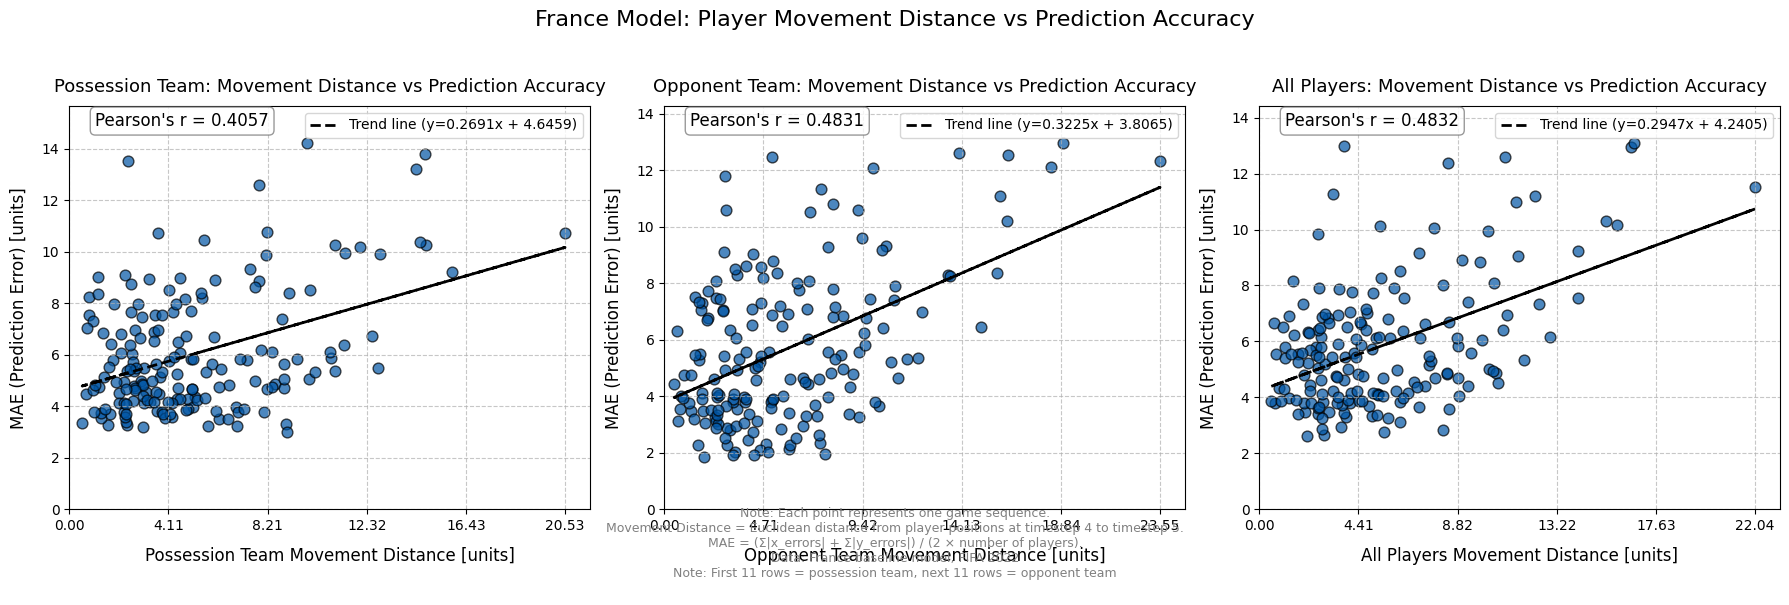


✅ STEP 2 COMPLETE: France player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 3.22 seconds

🎉 FRANCE PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/France_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using blue color (from French flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Correlations show moderate positive relationships, suggesting worse prediction accuracy with greater player movement
      Note: Correlation v

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/MAE_France_Player_Movement_vs_MAE.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE"
output_plot_path = os.path.join(output_dir, "France_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading France sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for France (blue from French flag)
france_color = '#0055A4'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('France Model: Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: France baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: France player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 FRANCE PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using blue color (from French flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Correlations show moderate positive relationships, suggesting worse prediction accuracy with greater player movement")
print("      Note: Correlation values: Possession = 0.4057, Opponent = 0.4831, All Players = 0.4832")

## **Tested_on_England**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/England/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5"
output_csv_path = os.path.join(output_dir, "MAE_England_Player_Movement_vs_MAE.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading England players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: England player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for England player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using England team colors (white background, red #C8102E) for visualization")

== STEP 1: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/England/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5/MAE_England_Player_Movement_vs_MAE.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5

📊 Loading England players CSV with memory optimization...
   ✅ CSV loaded in 0.39 seconds
   ✅ Shape: 204,204 rows, 5 columns
   ✅ Memory usage: 2.73 MB

🔍 Filtering

== STEP 2: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5/MAE_England_Player_Movement_vs_MAE.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5/England_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5

📊 Loading England sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 1,547 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 2.07 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players

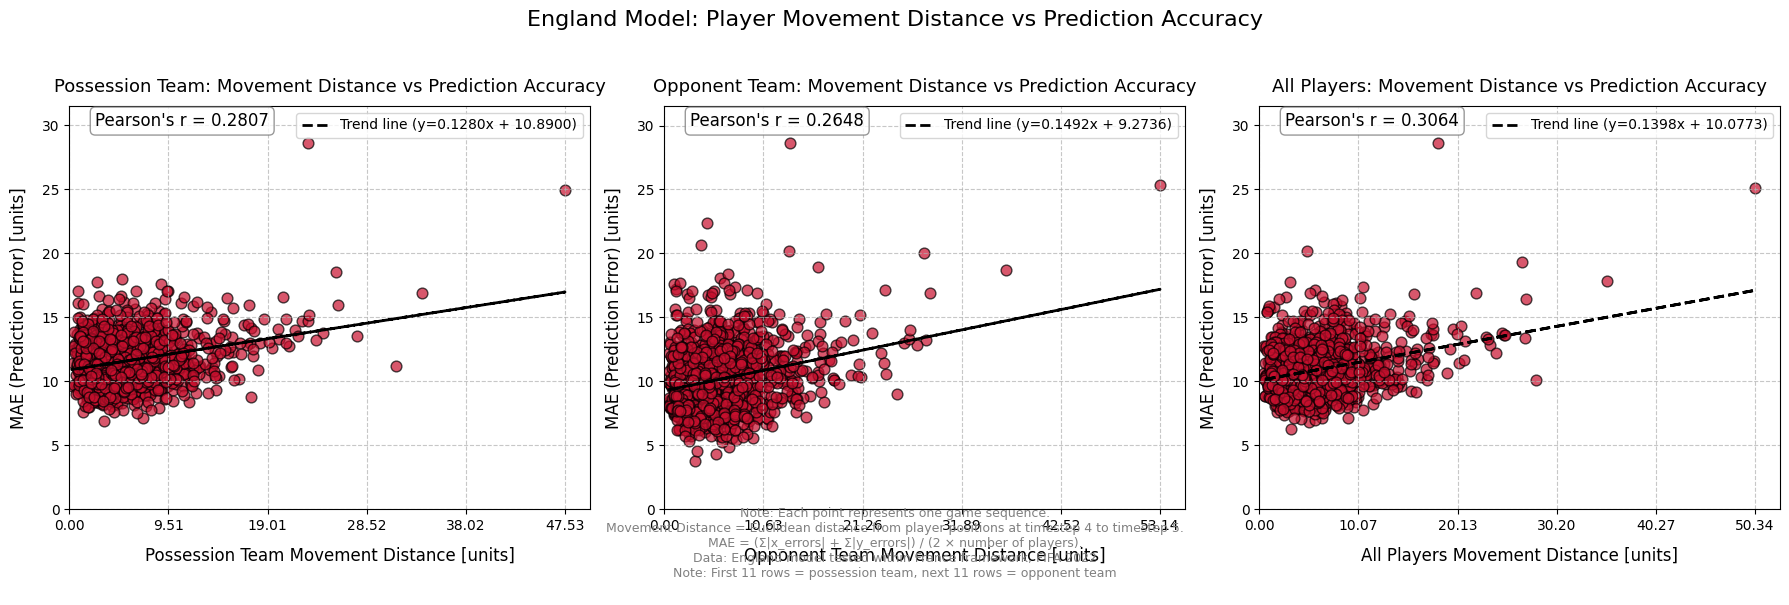


✅ STEP 2 COMPLETE: England player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 2.81 seconds

🎉 ENGLAND PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5/England_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from England flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Correlations show weak positive relationships, suggesting slightly worse prediction accuracy with greater player movement
   

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5/MAE_England_Player_Movement_vs_MAE.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/England_T4_T5"
output_plot_path = os.path.join(output_dir, "England_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading England sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for England (red from England flag)
england_color = '#C8102E'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('England Model: Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: England model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: England player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ENGLAND PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from England flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Correlations show weak positive relationships, suggesting slightly worse prediction accuracy with greater player movement")
print("      Note: Correlation values: Possession = 0.2807, Opponent = 0.2648, All Players = 0.3064")
print("      Note: England model tested within France framework")

## **Tested_on_Croatia**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Croatia/predictions/predicted_players_croatia.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5"
output_csv_path = os.path.join(output_dir, "MAE_Croatia_Player_Movement_vs_MAE.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Croatia players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Croatia player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Croatia player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using Croatia team colors (red-white #D52B1E, blue #00579F) for visualization")

== STEP 1: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Croatia/predictions/predicted_players_croatia.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5/MAE_Croatia_Player_Movement_vs_MAE.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5

📊 Loading Croatia players CSV with memory optimization...
   ✅ CSV loaded in 0.72 seconds
   ✅ Shape: 223,608 rows, 5 columns
   ✅ Memory usage: 2.99 MB

🔍 F

== STEP 2: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5/MAE_Croatia_Player_Movement_vs_MAE.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5/Croatia_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5

📊 Loading Croatia sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 1,694 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 2.03 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players

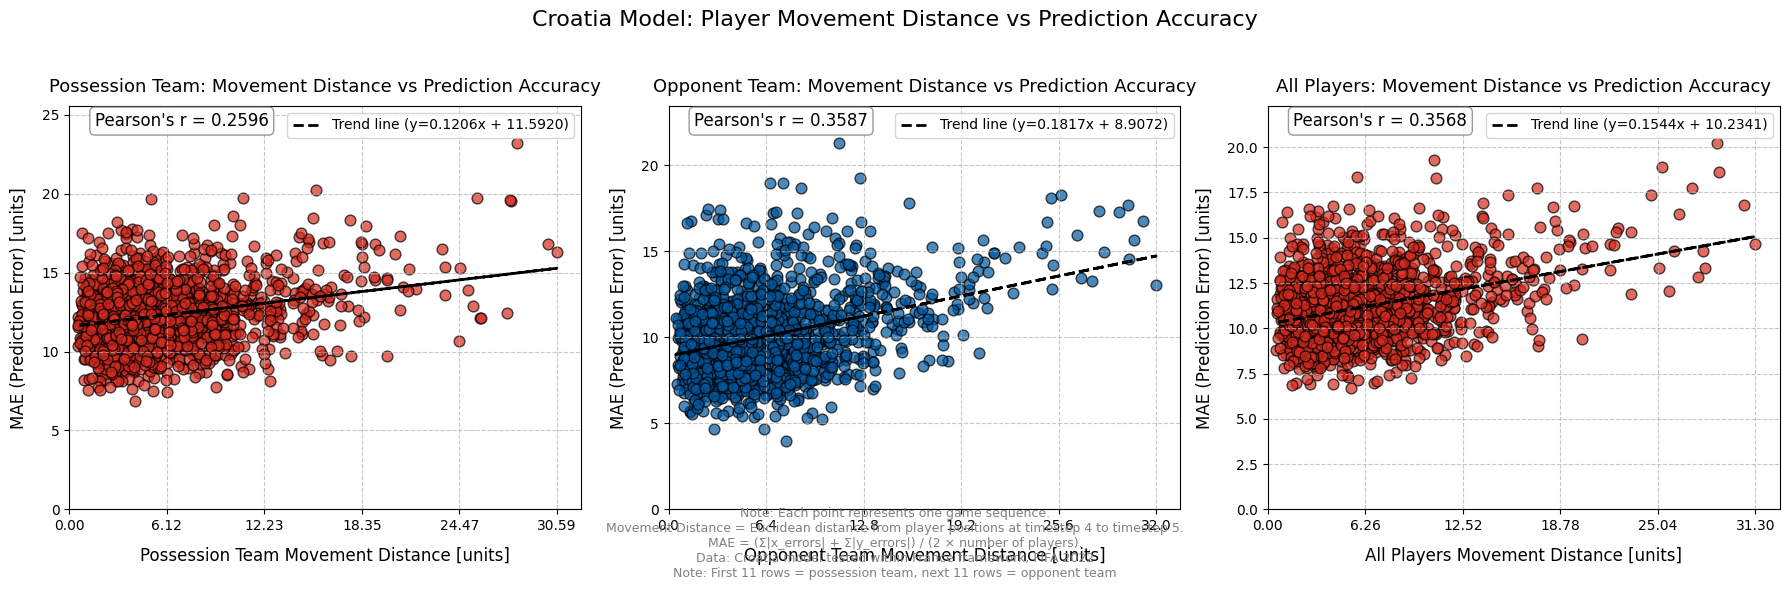


✅ STEP 2 COMPLETE: Croatia player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 2.54 seconds

🎉 CROATIA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5/Croatia_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using Croatia flag colors (red #D52B1E and blue #00579F) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Correlations show weak positive relationships, suggesting slightly worse prediction accuracy with greate

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5/MAE_Croatia_Player_Movement_vs_MAE.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Croatia_T4_T5"
output_plot_path = os.path.join(output_dir, "Croatia_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Croatia sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Colors for Croatia (red and blue from Croatia flag)
croatia_red = '#D52B1E'
croatia_blue = '#00579F'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=croatia_red,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=croatia_blue,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=croatia_red,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Croatia Model: Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Croatia model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Croatia player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 CROATIA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using Croatia flag colors (red #D52B1E and blue #00579F) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Correlations show weak positive relationships, suggesting slightly worse prediction accuracy with greater player movement")
print("      Note: Correlation values: Possession = 0.2596, Opponent = 0.3587, All Players = 0.3568")
print("      Note: Croatia model tested within France framework")

## **Tested_on_Morocco**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Morocco/predictions/predicted_players_morocco.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5"
output_csv_path = os.path.join(output_dir, "MAE_Morocco_Player_Movement_vs_MAE.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Morocco players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Morocco player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Morocco player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using Morocco team colors (red #C1272D, green #006233) for visualization")

== STEP 1: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Morocco/predictions/predicted_players_morocco.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5/MAE_Morocco_Player_Movement_vs_MAE.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5

📊 Loading Morocco players CSV with memory optimization...
   ✅ CSV loaded in 0.22 seconds
   ✅ Shape: 112,596 rows, 5 columns
   ✅ Memory usage: 1.50 MB

🔍 F

== STEP 2: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5/MAE_Morocco_Player_Movement_vs_MAE.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5/Morocco_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5

📊 Loading Morocco sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 853 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 1.77 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_M

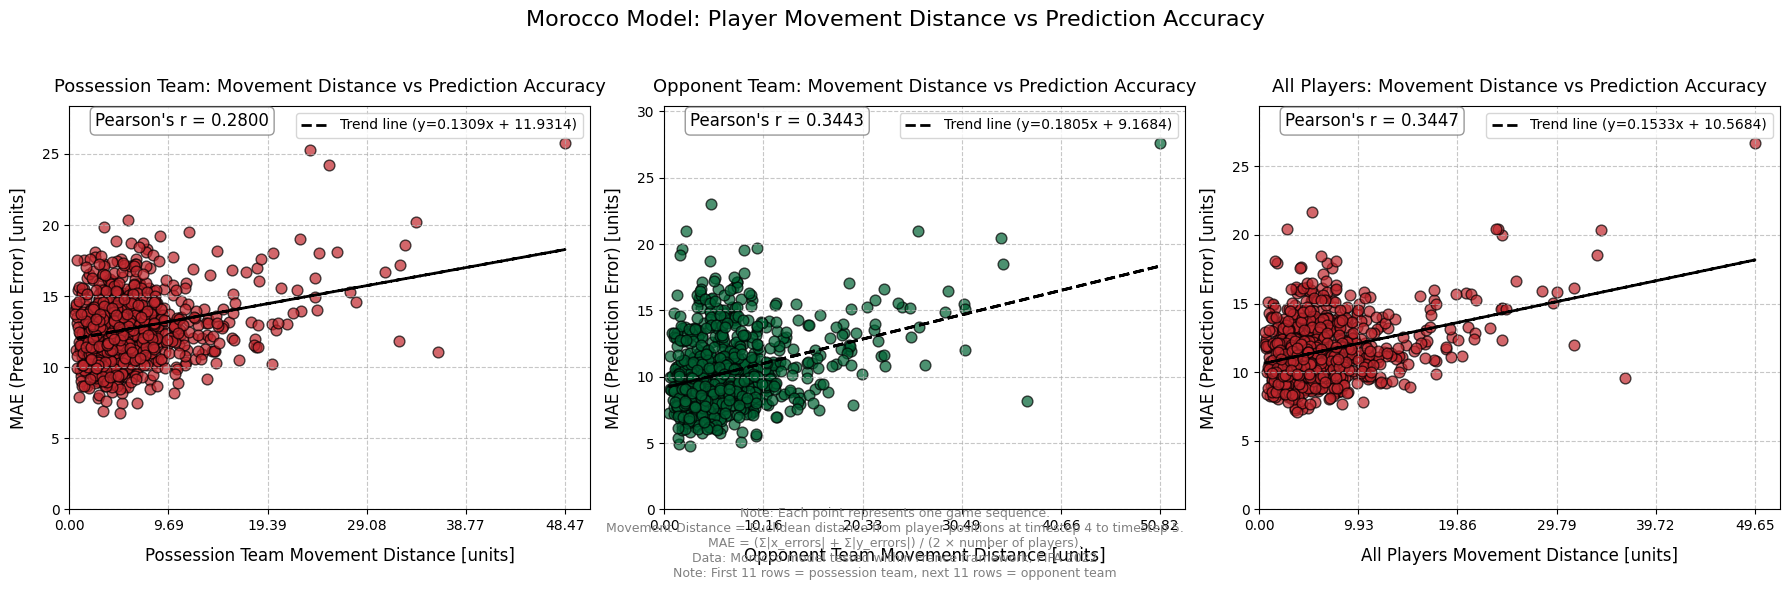


✅ STEP 2 COMPLETE: Morocco player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 2.27 seconds

🎉 MOROCCO PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5/Morocco_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using Morocco flag colors (red #C1272D and green #006233) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Correlations show weak positive relationships, suggesting slightly worse prediction accuracy with great

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5/MAE_Morocco_Player_Movement_vs_MAE.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Morocco_T4_T5"
output_plot_path = os.path.join(output_dir, "Morocco_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Morocco sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Colors for Morocco (red and green from Morocco flag)
morocco_red = '#C1272D'
morocco_green = '#006233'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=morocco_red,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=morocco_green,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=morocco_red,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Morocco Model: Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Morocco model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Morocco player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MOROCCO PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using Morocco flag colors (red #C1272D and green #006233) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Correlations show weak positive relationships, suggesting slightly worse prediction accuracy with greater player movement")
print("      Note: Correlation values: Possession = 0.2800, Opponent = 0.3443, All Players = 0.3447")
print("      Note: Morocco model tested within France framework")

## **Tested_on_Argentina**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Argentina/predictions/predicted_players_argentina.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5"
output_csv_path = os.path.join(output_dir, "MAE_Argentina_Player_Movement_vs_MAE.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Argentina players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Argentina player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Argentina player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using Argentina team colors (light blue #65C1E7, white) for visualization")

== STEP 1: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Argentina/predictions/predicted_players_argentina.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5/MAE_Argentina_Player_Movement_vs_MAE.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5

📊 Loading Argentina players CSV with memory optimization...
   ✅ CSV loaded in 0.53 seconds
   ✅ Shape: 266,112 rows, 5 columns
   ✅ Memory usa

== STEP 2: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5/MAE_Argentina_Player_Movement_vs_MAE.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5/Argentina_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5

📊 Loading Argentina sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 2,016 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 1.95 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Resul

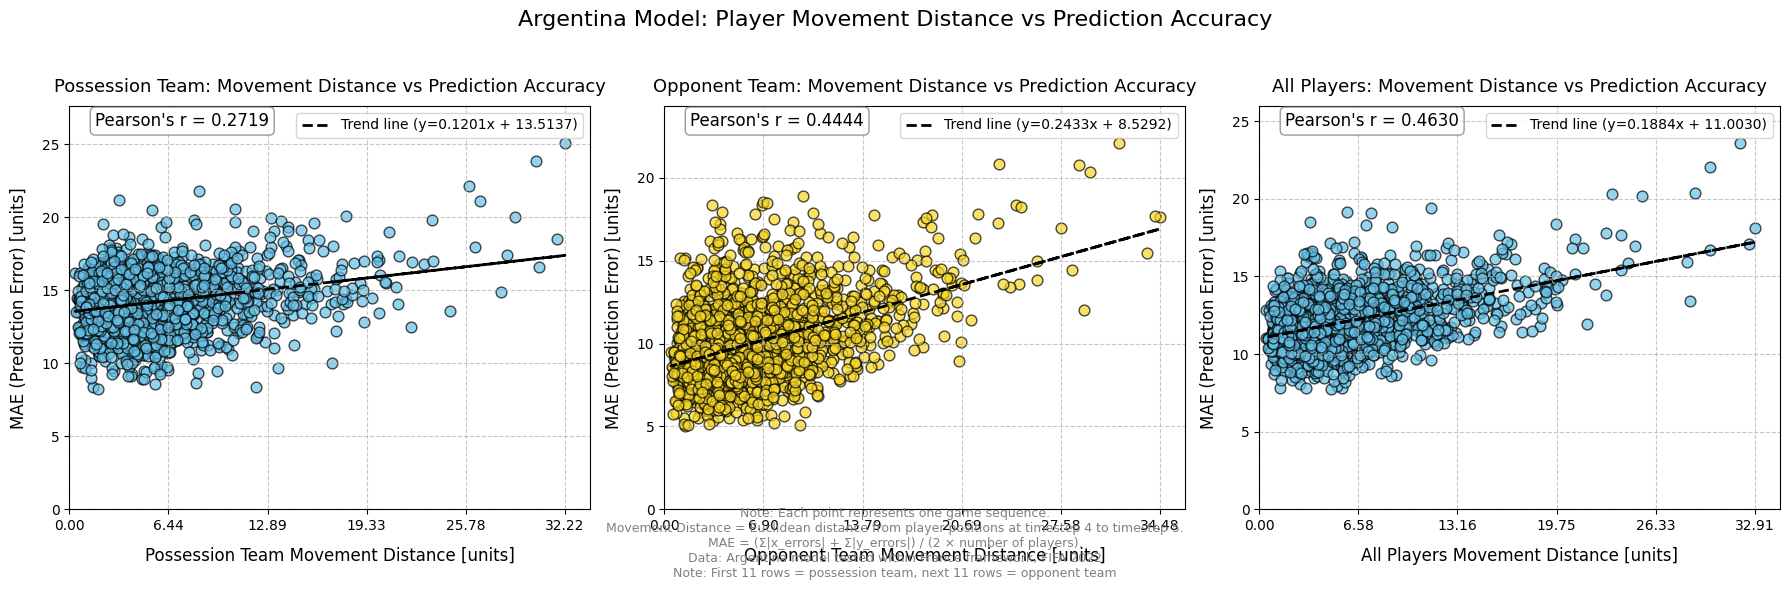


✅ STEP 2 COMPLETE: Argentina player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 2.46 seconds

🎉 ARGENTINA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5/Argentina_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using Argentina flag colors (light blue #65C1E7 and gold #F7D726) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Correlations show weak to moderate positive relationships, suggesting worse prediction 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5/MAE_Argentina_Player_Movement_vs_MAE.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Players_Movement_vs_MAE/Argentina_T4_T5"
output_plot_path = os.path.join(output_dir, "Argentina_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Argentina sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Colors for Argentina (light blue and white from Argentina flag)
argentina_blue = '#65C1E7'
argentina_white = 'white'
argentina_gold = '#F7D726'  # Adding gold as a contrasting color for opponent team

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=argentina_blue,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=argentina_gold,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=argentina_blue,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Argentina Model: Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Argentina model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Argentina player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ARGENTINA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using Argentina flag colors (light blue #65C1E7 and gold #F7D726) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Correlations show weak to moderate positive relationships, suggesting worse prediction accuracy with greater player movement")
print("      Note: Correlation values: Possession = 0.2719, Opponent = 0.4444, All Players = 0.4630")
print("      Note: Argentina model tested within France framework")

# **MAE_Players_Movements_T4_T5_Baseline_Model**

## **Tested_on_Baseline_Data**

In [ ]:
# Step 1: Baseline dataset analysis using baseline model
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: BASELINE DATASET SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements"
output_csv_path = os.path.join(output_dir, "MAE_Baseline_T4_T5_Players_Movements.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading baseline dataset CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Baseline dataset player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for baseline dataset player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Data: Baseline dataset tested on baseline model")

== STEP 1: BASELINE DATASET SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/MAE_Baseline_T4_T5_Players_Movements.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements


== STEP 2: BASELINE DATASET SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/MAE_Baseline_T4_T5_Players_Movements.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Baseline_T4_T5_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements

📊 Loading baseline dataset sequence-level metrics CSV...
   ✅ CSV loaded in 0.02 seconds
   ✅ Shape: 1,504 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 3.55 s

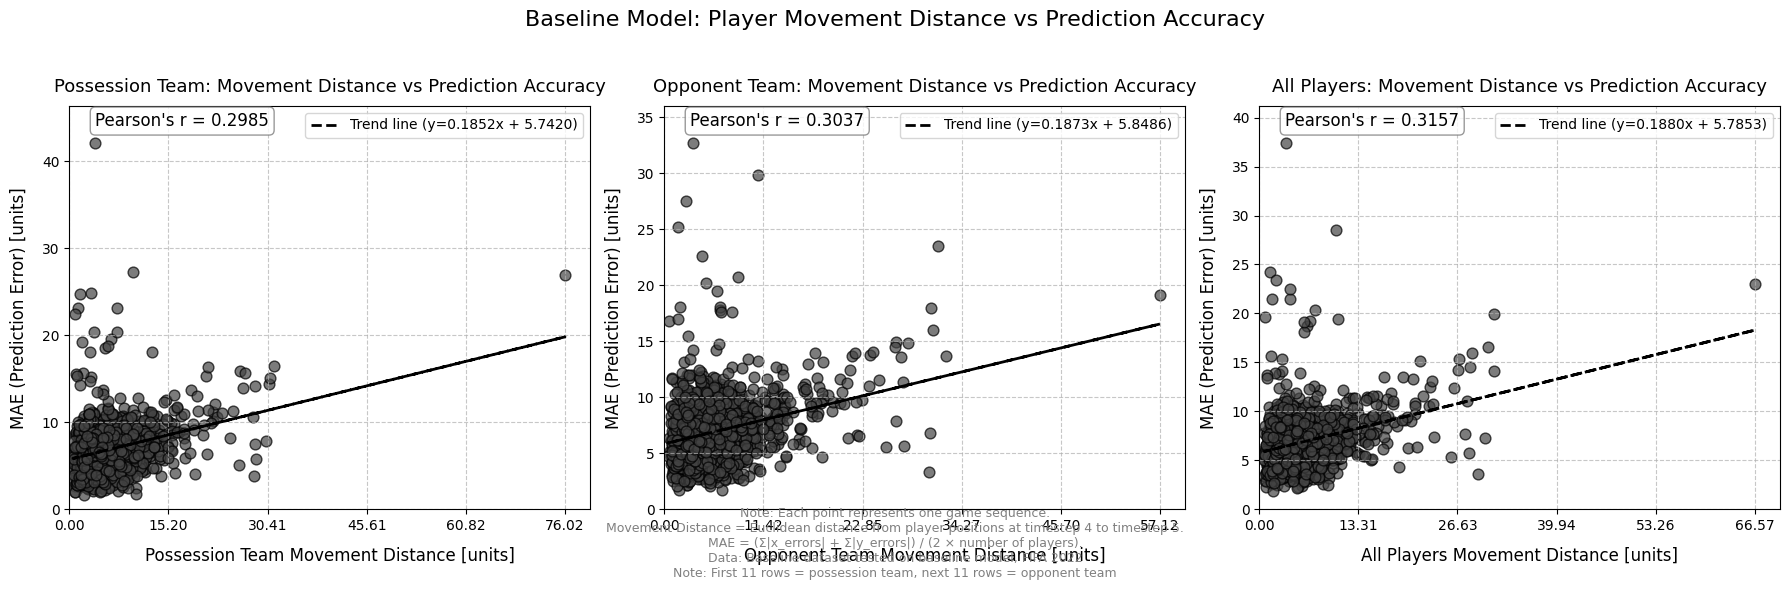


✅ STEP 2 COMPLETE: Baseline dataset player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 4.50 seconds

🎉 BASELINE DATASET PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Baseline_T4_T5_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using neutral dark gray color for visualization
      Data: Baseline dataset tested on baseline model
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
# Step 2: Baseline dataset visualization using baseline model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: BASELINE DATASET SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/MAE_Baseline_T4_T5_Players_Movements.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements"
output_plot_path = os.path.join(output_dir, "Baseline_T4_T5_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading baseline dataset sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for baseline dataset (neutral dark gray)
baseline_color = '#444444'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=baseline_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=baseline_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=baseline_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Baseline dataset tested on baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Baseline dataset player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 BASELINE DATASET PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using neutral dark gray color for visualization")
print("      Data: Baseline dataset tested on baseline model")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_France**

In [ ]:
# Step 1: France data analysis using baseline model
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/France_Test/predictions/predicted_players_france.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France"
output_csv_path = os.path.join(output_dir, "MAE_France_T4_T5_Players_Movements.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading France players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: France player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for France player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Data: France players tested on baseline model")

== STEP 1: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/France_Test/predictions/predicted_players_france.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France/MAE_France_T4_T5_Players_Movements.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T

== STEP 2: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France/MAE_France_T4_T5_Players_Movements.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France/France_T4_T5_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France

📊 Loading France sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 1,617 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 6.20 seco

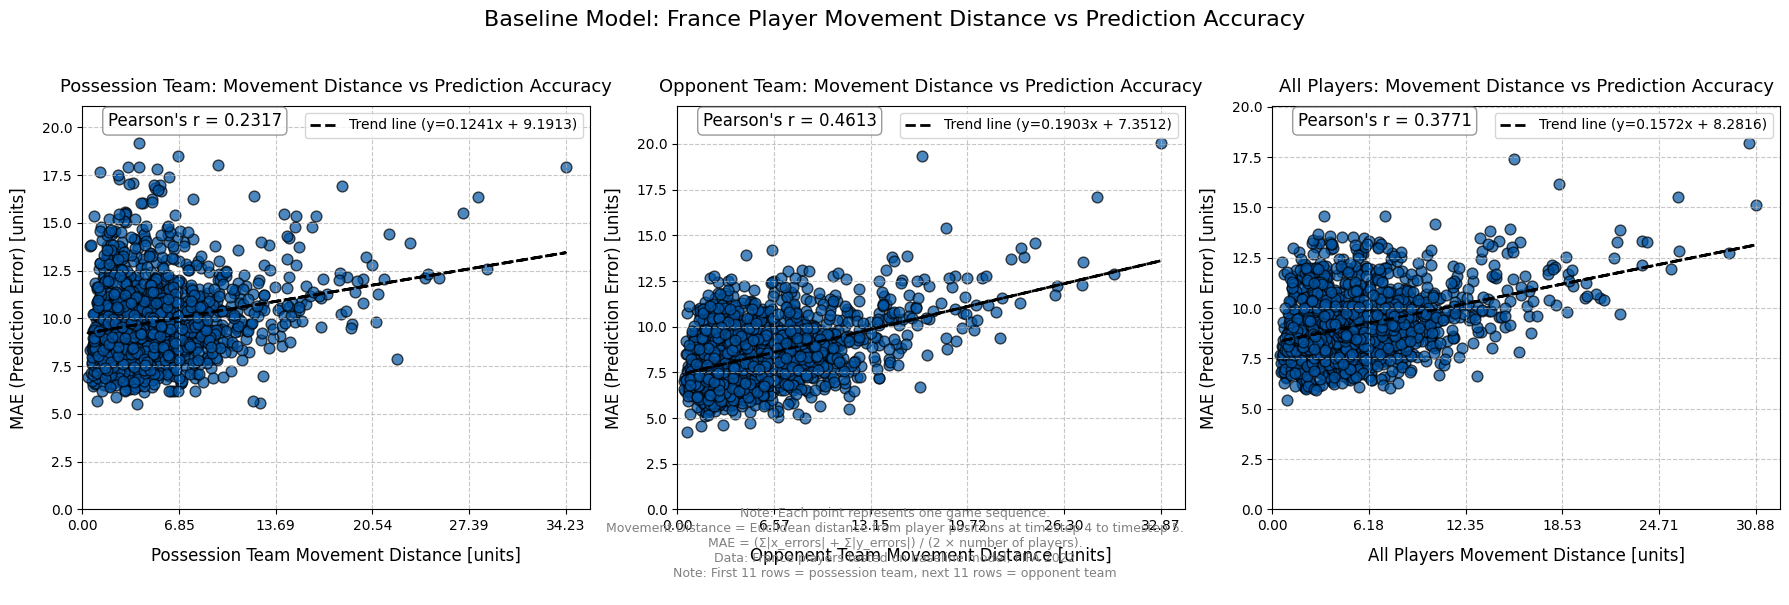


✅ STEP 2 COMPLETE: France player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 7.22 seconds

🎉 FRANCE PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France/France_T4_T5_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using blue color (from French flag) for visualization
      Data: France players tested on baseline model
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
# Step 2: France data visualization using baseline model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: FRANCE SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France/MAE_France_T4_T5_Players_Movements.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/France"
output_plot_path = os.path.join(output_dir, "France_T4_T5_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading France sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for France (blue from French flag)
france_color = '#0055A4'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: France Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: France players tested on baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: France player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 FRANCE PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using blue color (from French flag) for visualization")
print("      Data: France players tested on baseline model")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_England**

In [ ]:
# Step 1: England data analysis using baseline model
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/England_Test/predictions/predicted_players_england.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England"
output_csv_path = os.path.join(output_dir, "MAE_England_T4_T5_Players_Movements.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading England players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: England player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for England player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Data: England players tested on baseline model")

== STEP 1: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/England_Test/predictions/predicted_players_england.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England/MAE_England_T4_T5_Players_Movements.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MA

== STEP 2: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England/MAE_England_T4_T5_Players_Movements.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England/England_T4_T5_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England

📊 Loading England sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 1,547 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 4.

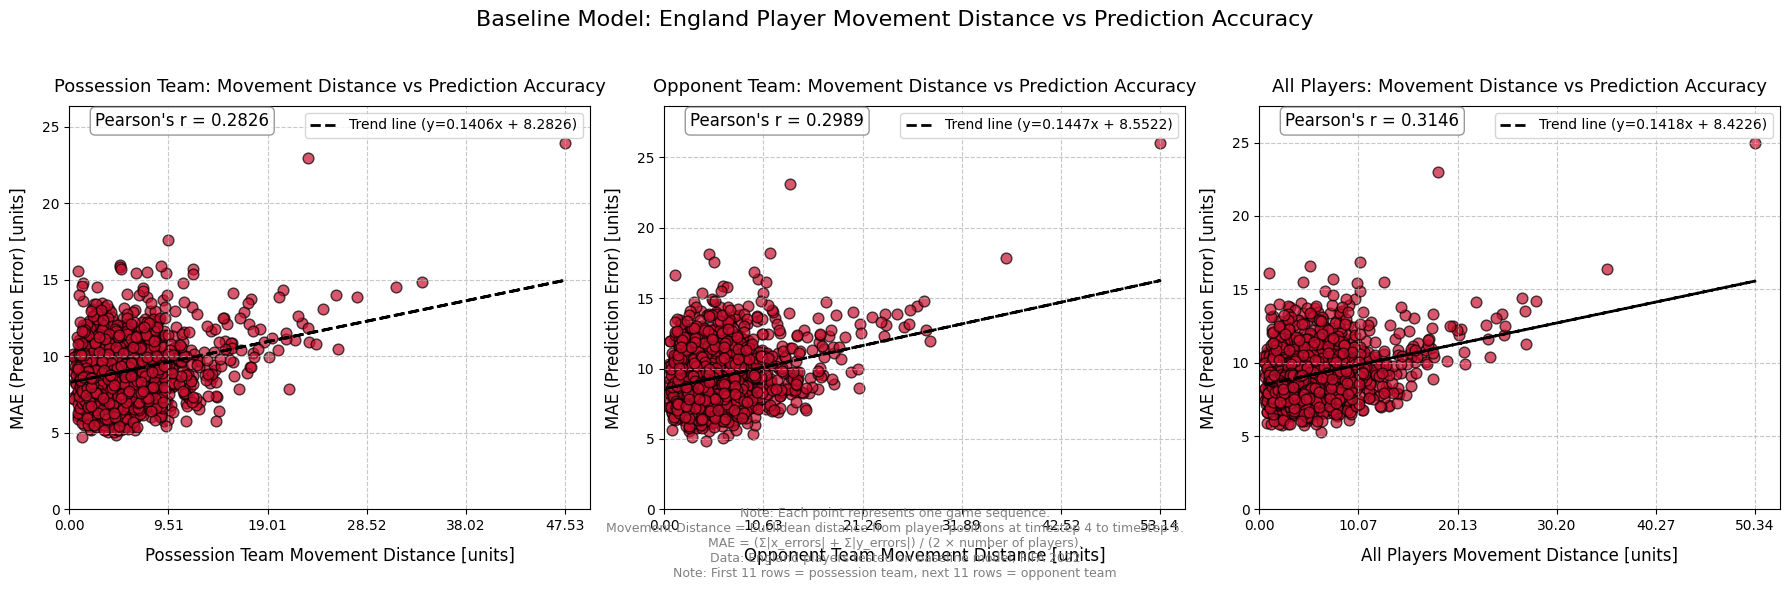


✅ STEP 2 COMPLETE: England player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 5.02 seconds

🎉 ENGLAND PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England/England_T4_T5_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from English flag) for visualization
      Data: England players tested on baseline model
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
# Step 2: England data visualization using baseline model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ENGLAND SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England/MAE_England_T4_T5_Players_Movements.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/England"
output_plot_path = os.path.join(output_dir, "England_T4_T5_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading England sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for England (red from English flag)
england_color = '#C8102E'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: England Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: England players tested on baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: England player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ENGLAND PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from English flag) for visualization")
print("      Data: England players tested on baseline model")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_Croatia**

In [ ]:
# Step 1: Croatia data analysis using baseline model
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Croatia_Test/predictions/predicted_players_croatia.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia"
output_csv_path = os.path.join(output_dir, "MAE_Croatia_T4_T5_Players_Movements.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Croatia players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Croatia player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Croatia player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Data: Croatia players tested on baseline model")

== STEP 1: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Croatia_Test/predictions/predicted_players_croatia.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia/MAE_Croatia_T4_T5_Players_Movements.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MA

== STEP 2: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia/MAE_Croatia_T4_T5_Players_Movements.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia/Croatia_T4_T5_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia

📊 Loading Croatia sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 1,694 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 4.

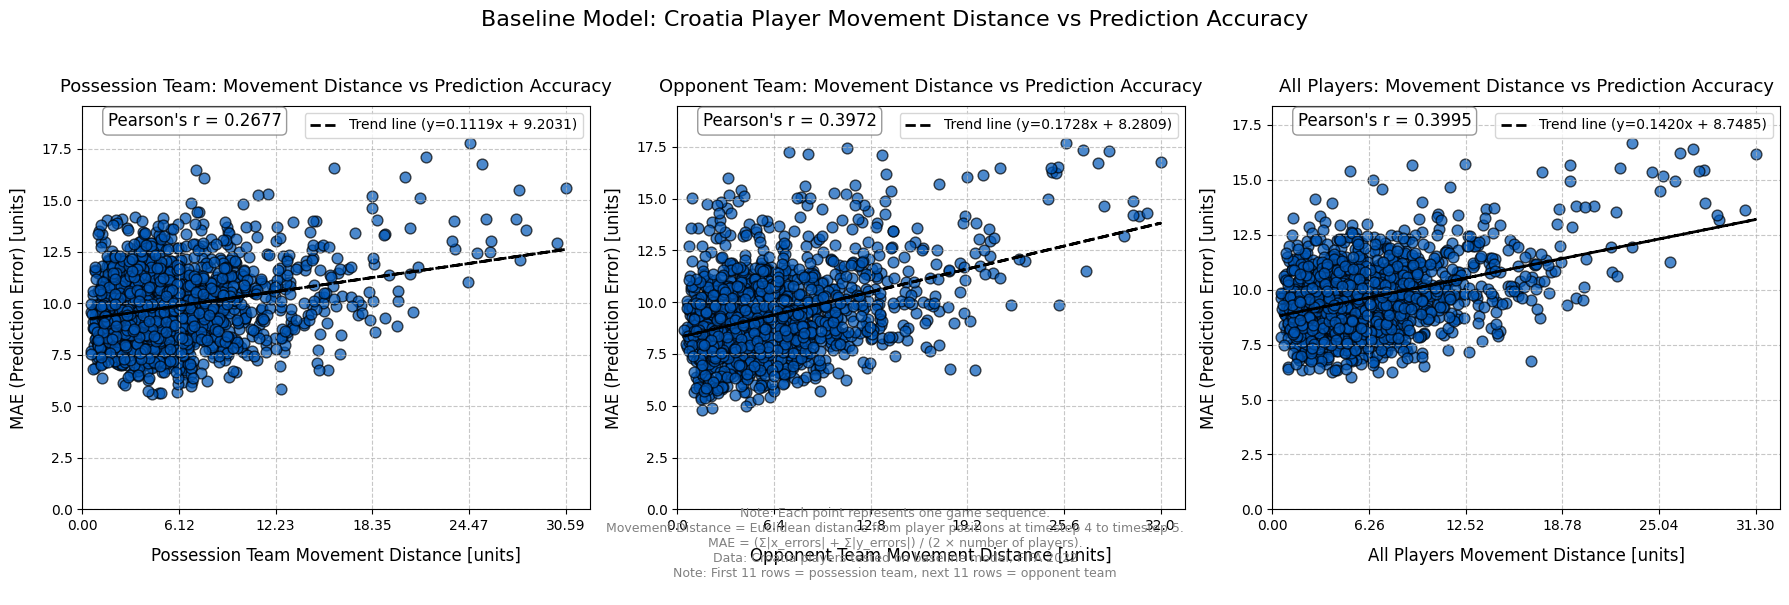


✅ STEP 2 COMPLETE: Croatia player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 6.12 seconds

🎉 CROATIA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia/Croatia_T4_T5_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using blue color (from Croatian flag) for visualization
      Data: Croatia players tested on baseline model
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
# Step 2: Croatia data visualization using baseline model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: CROATIA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia/MAE_Croatia_T4_T5_Players_Movements.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Croatia"
output_plot_path = os.path.join(output_dir, "Croatia_T4_T5_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Croatia sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for Croatia (blue from Croatian flag)
croatia_color = '#0057B8'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: Croatia Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Croatia players tested on baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Croatia player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 CROATIA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using blue color (from Croatian flag) for visualization")
print("      Data: Croatia players tested on baseline model")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_Morocco**

In [ ]:
# Step 1: Morocco data analysis using baseline model
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Morocco_Test/predictions/predicted_players_morocco.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco"
output_csv_path = os.path.join(output_dir, "MAE_Morocco_T4_T5_Players_Movements.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Morocco players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Morocco player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Morocco player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Data: Morocco players tested on baseline model")

== STEP 1: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Morocco_Test/predictions/predicted_players_morocco.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco/MAE_Morocco_T4_T5_Players_Movements.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MA

== STEP 2: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco/MAE_Morocco_T4_T5_Players_Movements.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco/Morocco_T4_T5_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco

📊 Loading Morocco sequence-level metrics CSV...
   ✅ CSV loaded in 0.03 seconds
   ✅ Shape: 853 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 3.61

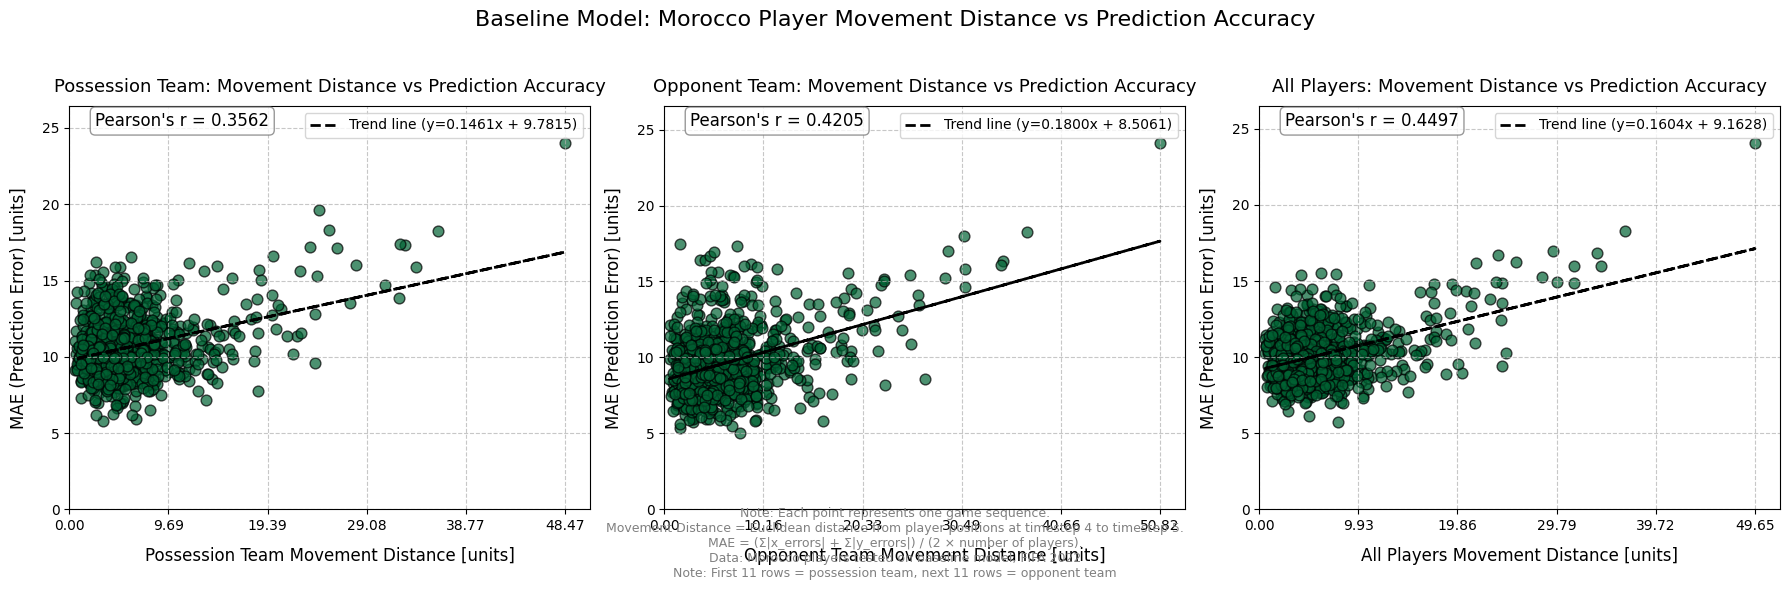


✅ STEP 2 COMPLETE: Morocco player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 4.46 seconds

🎉 MOROCCO PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco/Morocco_T4_T5_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using green color (from Moroccan flag) for visualization
      Data: Morocco players tested on baseline model
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
# Step 2: Morocco data visualization using baseline model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: MOROCCO SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco/MAE_Morocco_T4_T5_Players_Movements.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Morocco"
output_plot_path = os.path.join(output_dir, "Morocco_T4_T5_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Morocco sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for Morocco (green from Moroccan flag)
morocco_color = '#006233'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: Morocco Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Morocco players tested on baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Morocco player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MOROCCO PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using green color (from Moroccan flag) for visualization")
print("      Data: Morocco players tested on baseline model")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_Argentina**

In [ ]:
# Step 1: Argentina data analysis using baseline model
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Argentina_Test/predictions/predicted_players_argentina.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina"
output_csv_path = os.path.join(output_dir, "MAE_Argentina_T4_T5_Players_Movements.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Argentina players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate movement distances for possession team (first 11 players)
    possession_t4 = t4.iloc[:11]
    possession_t5 = t5_actual.iloc[:11]

    possession_distances = np.sqrt(
        (possession_t5['x'].values - possession_t4['x'].values)**2 +
        (possession_t5['y'].values - possession_t4['y'].values)**2
    )
    avg_possession_distance = np.mean(possession_distances)

    # Calculate movement distances for opponent team (next 11 players)
    opponent_t4 = t4.iloc[11:22]
    opponent_t5 = t5_actual.iloc[11:22]

    opponent_distances = np.sqrt(
        (opponent_t5['x'].values - opponent_t4['x'].values)**2 +
        (opponent_t5['y'].values - opponent_t4['y'].values)**2
    )
    avg_opponent_distance = np.mean(opponent_distances)

    # Calculate movement distances for all players
    all_distances = np.sqrt(
        (t5_actual['x'].values - t4['x'].values)**2 +
        (t5_actual['y'].values - t4['y'].values)**2
    )
    avg_all_distance = np.mean(all_distances)

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(possession_t5['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(possession_t5['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(opponent_t5['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(opponent_t5['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'avg_players_distance_possession_team': float(avg_possession_distance),
        'avg_players_distance_opponent_team': float(avg_opponent_distance),
        'avg_players_distance_all_players': float(avg_all_distance),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'avg_players_distance_possession_team',
    'avg_players_distance_opponent_team',
    'avg_players_distance_all_players',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Dist={row['avg_players_distance_possession_team']:.3f}, Opp Dist={row['avg_players_distance_opponent_team']:.3f}, All Dist={row['avg_players_distance_all_players']:.3f}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Movement Distance: {results_df['avg_players_distance_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team Movement Distance: {results_df['avg_players_distance_opponent_team'].mean():.3f} units")
print(f"   • Average All Players Movement Distance: {results_df['avg_players_distance_all_players'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")
print(f"   • Correlation (Possession Dist vs Possession MAE): {results_df['avg_players_distance_possession_team'].corr(results_df['MAE_possession_team']):.4f}")
print(f"   • Correlation (Opponent Dist vs Opponent MAE): {results_df['avg_players_distance_opponent_team'].corr(results_df['MAE_opponent_team']):.4f}")
print(f"   • Correlation (All Players Dist vs All Players MAE): {results_df['avg_players_distance_all_players'].corr(results_df['MAE_all_players']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Argentina player movement distance vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Argentina player movement distance vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Player Movement Distance = Euclidean distance from player position at t=4 to position at t=5")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Data: Argentina players tested on baseline model")

== STEP 1: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Argentina_Test/predictions/predicted_players_argentina.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina/MAE_Argentina_T4_T5_Players_Movements.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Differen

== STEP 2: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina/MAE_Argentina_T4_T5_Players_Movements.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina/Argentina_T4_T5_Player_Movement_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina

📊 Loading Argentina sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 2,016 rows, 7 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization g

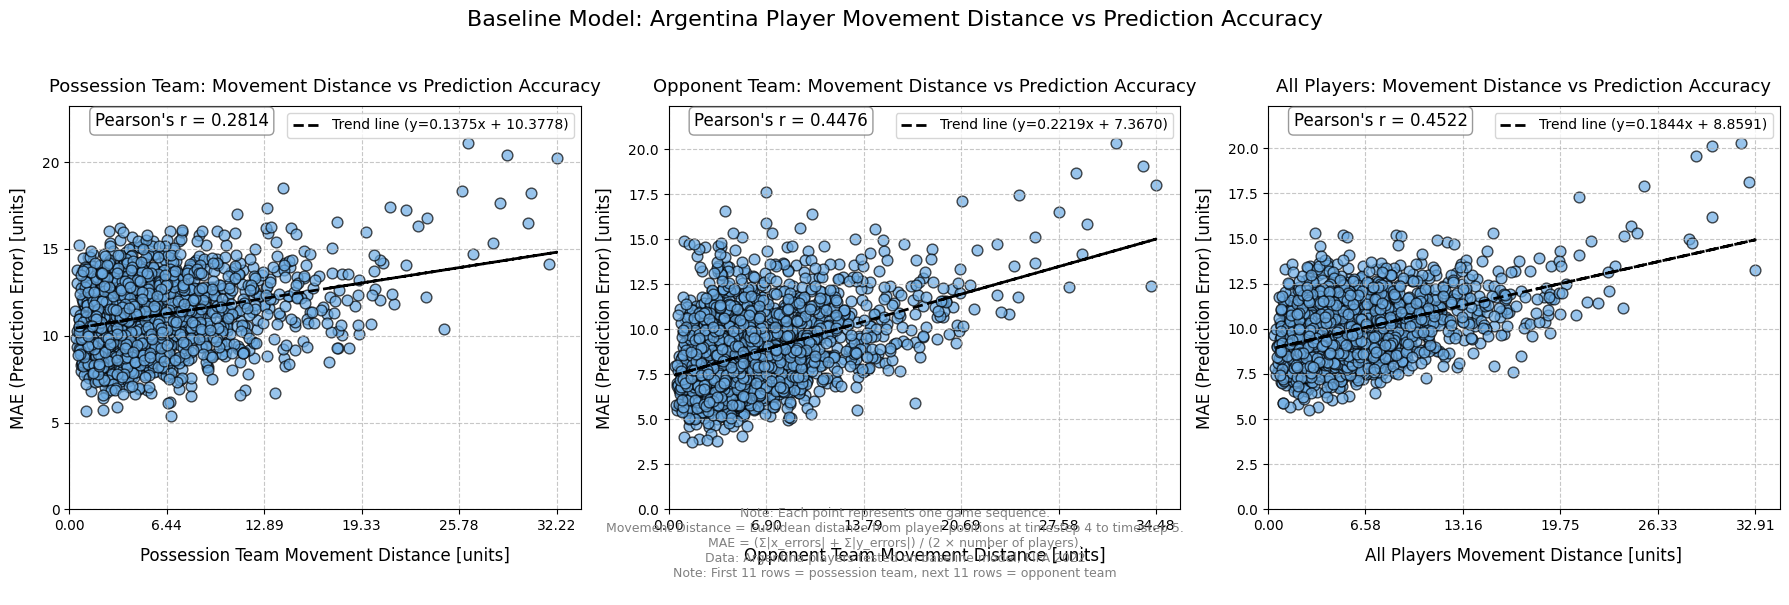


✅ STEP 2 COMPLETE: Argentina player movement distance vs MAE visualization generation finished
   ⏱️  Total execution time: 5.28 seconds

🎉 ARGENTINA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina/Argentina_T4_T5_Player_Movement_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team movement distance vs MAE
      • Middle: Opponent team movement distance vs MAE
      • Right: All players movement distance vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using light blue color (from Argentine flag) for visualization
      Data: Argentina players tested on baseline model
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
# Step 2: Argentina data visualization using baseline model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ARGENTINA SEQUENCE-LEVEL PLAYER MOVEMENT DISTANCE vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina/MAE_Argentina_T4_T5_Players_Movements.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_T5_Players_Movements/Argentina"
output_plot_path = os.path.join(output_dir, "Argentina_T4_T5_Player_Movement_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Argentina sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'avg_players_distance_possession_team', 'avg_players_distance_opponent_team',
    'avg_players_distance_all_players', 'MAE_possession_team',
    'MAE_opponent_team', 'MAE_all_players'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for Argentina (light blue from Argentine flag)
argentina_color = '#6CACE4'

# Subplot 1: Possession Team Movement Distance vs MAE
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_possession_team'],
    metrics_df['MAE_possession_team'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['avg_players_distance_possession_team'], metrics_df['MAE_possession_team'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['avg_players_distance_possession_team'],
    p_poss(metrics_df['avg_players_distance_possession_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title
plt.xlabel('Possession Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_poss_dist = metrics_df['avg_players_distance_possession_team'].max()
plt.xlim(0, max_poss_dist * 1.05)
plt.xticks(np.arange(0, max_poss_dist + 1, max(0.5, max_poss_dist/5)))
plt.ylim(0, metrics_df['MAE_possession_team'].max() * 1.1)

# Add correlation coefficient
poss_correlation = metrics_df['avg_players_distance_possession_team'].corr(metrics_df['MAE_possession_team'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team Movement Distance vs MAE
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_opponent_team'],
    metrics_df['MAE_opponent_team'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['avg_players_distance_opponent_team'], metrics_df['MAE_opponent_team'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['avg_players_distance_opponent_team'],
    p_opp(metrics_df['avg_players_distance_opponent_team']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title
plt.xlabel('Opponent Team Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_opp_dist = metrics_df['avg_players_distance_opponent_team'].max()
plt.xlim(0, max_opp_dist * 1.05)
plt.xticks(np.arange(0, max_opp_dist + 1, max(0.5, max_opp_dist/5)))
plt.ylim(0, metrics_df['MAE_opponent_team'].max() * 1.1)

# Add correlation coefficient
opp_correlation = metrics_df['avg_players_distance_opponent_team'].corr(metrics_df['MAE_opponent_team'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players Movement Distance vs MAE
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['avg_players_distance_all_players'],
    metrics_df['MAE_all_players'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['avg_players_distance_all_players'], metrics_df['MAE_all_players'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['avg_players_distance_all_players'],
    p_all(metrics_df['avg_players_distance_all_players']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title
plt.xlabel('All Players Movement Distance [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Movement Distance vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes
max_all_dist = metrics_df['avg_players_distance_all_players'].max()
plt.xlim(0, max_all_dist * 1.05)
plt.xticks(np.arange(0, max_all_dist + 1, max(0.5, max_all_dist/5)))
plt.ylim(0, metrics_df['MAE_all_players'].max() * 1.1)

# Add correlation coefficient
all_correlation = metrics_df['avg_players_distance_all_players'].corr(metrics_df['MAE_all_players'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: Argentina Player Movement Distance vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Movement Distance = Euclidean distance from player positions at timestep 4 to timestep 5.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Argentina players tested on baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team\n",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_possession_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmin(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_possession_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_possession_team'].idxmax(), 'avg_players_distance_possession_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_possession_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_possession_team'].max():.3f})")
print(f"   • Opponent Team Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_opponent_team'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmin(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_opponent_team'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_opponent_team'].idxmax(), 'avg_players_distance_opponent_team']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_opponent_team'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_opponent_team'].max():.3f})")
print(f"   • All Players Movement Distance:")
print(f"     - Minimum MAE: {metrics_df['MAE_all_players'].min():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmin(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Maximum MAE: {metrics_df['MAE_all_players'].max():.3f} units (at distance = {metrics_df.loc[metrics_df['MAE_all_players'].idxmax(), 'avg_players_distance_all_players']:.3f})")
print(f"     - Shortest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmin(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].min():.3f})")
print(f"     - Longest movement: Sequence ID {metrics_df.loc[metrics_df['avg_players_distance_all_players'].idxmax(), 'global_sequence_id']} (distance = {metrics_df['avg_players_distance_all_players'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Distance vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team movement and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team movement and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team movement and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team movement and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team movement and prediction error")

print(f"   • Opponent Team Distance vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team movement and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team movement and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team movement and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team movement and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team movement and prediction error")

print(f"   • All Players Distance vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players movement and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players movement and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players movement and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players movement and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players movement and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players movement and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players movement and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Argentina player movement distance vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ARGENTINA PLAYER MOVEMENT DISTANCE VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team movement distance vs MAE")
print("      • Middle: Opponent team movement distance vs MAE")
print("      • Right: All players movement distance vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using light blue color (from Argentine flag) for visualization")
print("      Data: Argentina players tested on baseline model")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

# **MAE_Players_Movements_Correlation_Results_Figure**

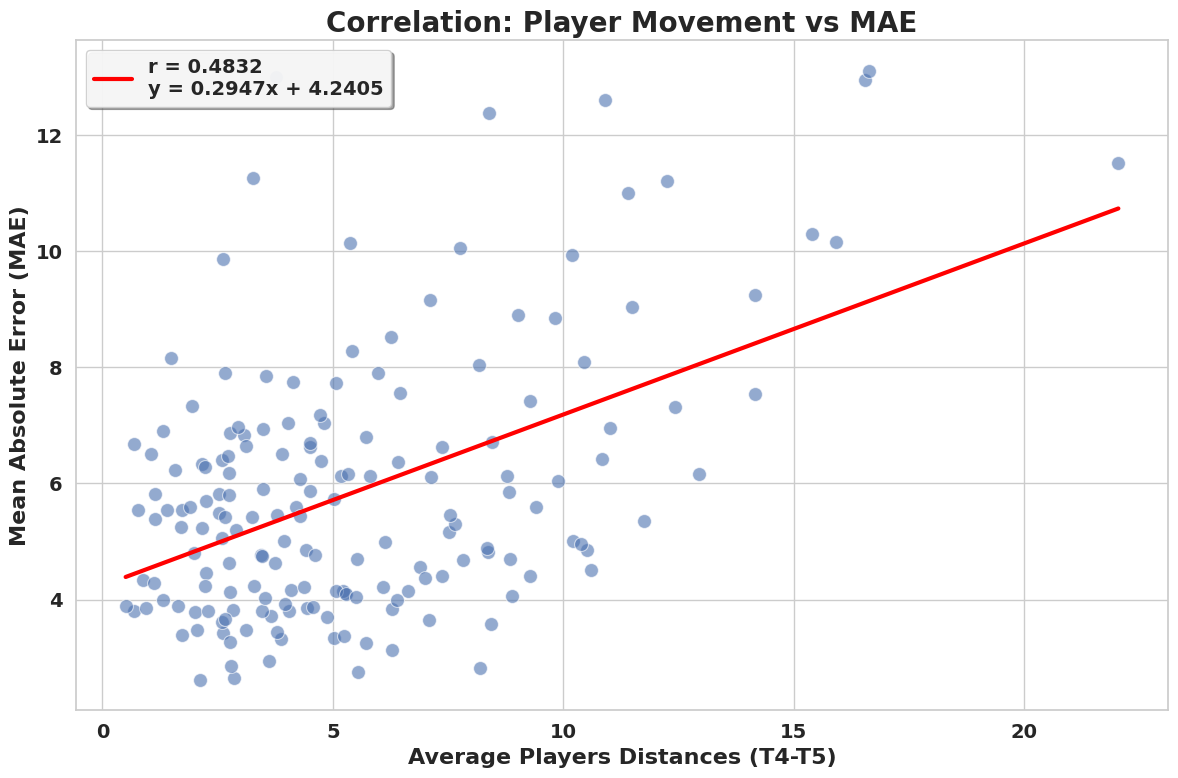

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Load the Data
# Ensure the file name matches exactly what you upload to Colab
file_name = 'MAE_France_Player_Movement_vs_MAE.csv'
df = pd.read_csv(file_name)

# 2. Calculate Correlation and Line Equation
# We use scipy.stats.linregress to get all necessary statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df['avg_players_distances_T4_T5'],
    df['MAE']
)

# Format the equation string (handling the sign of the intercept)
sign = '+' if intercept >= 0 else '-'
line_eq = f"y = {slope:.4f}x {sign} {abs(intercept):.4f}"
corr_text = f"r = {r_value:.4f}"

# Combine them for the legend label
legend_text = f"{corr_text}\n{line_eq}"

# 3. Professional Styling
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

plt.figure(figsize=(12, 8))

# 4. Plotting
# Scatter points
sns.scatterplot(
    data=df,
    x='avg_players_distances_T4_T5',
    y='MAE',
    s=100,            # Larger point size
    alpha=0.6,        # Slight transparency
    edgecolor='white' # White border around dots for clarity
)

# 5. Add the Regression Line with the Legend Label
# Generate x-values for the line based on the data range
x_range = np.linspace(
    df['avg_players_distances_T4_T5'].min(),
    df['avg_players_distances_T4_T5'].max(),
    100
)
y_range = slope * x_range + intercept

# Plot the line
plt.plot(
    x_range,
    y_range,
    color='red',
    linewidth=3,
    label=legend_text  # This adds our calculated text to the legend
)

# 6. Final Polish
plt.legend(
    loc='upper left',     # <--- Changed this from 'best' to 'upper left'
    frameon=True,         # Box around the legend
    shadow=True,          # Shadow for depth
    facecolor='white',    # White background
    framealpha=0.9        # Slightly opaque
)

plt.title('Correlation: Player Movement vs MAE')
plt.xlabel('Average Players Distances (T4-T5)')
plt.ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()

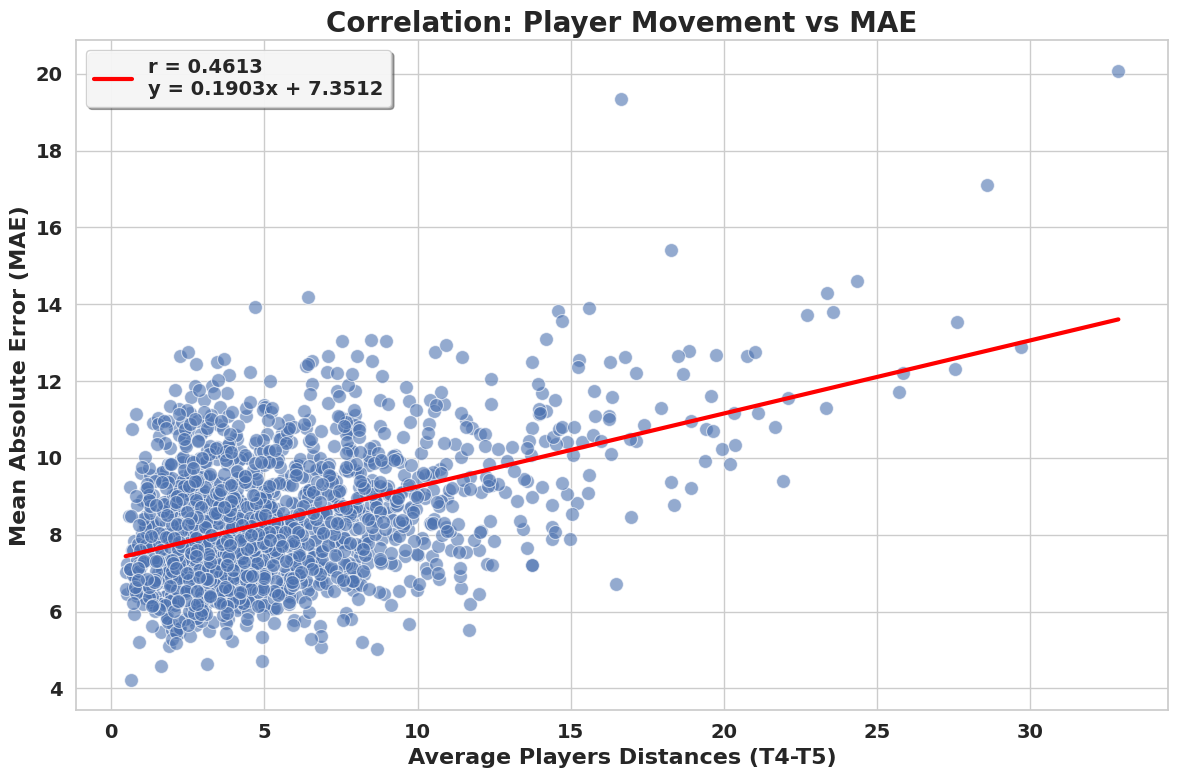

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Load the Data
# Ensure the file name matches exactly what you upload to Colab
file_name = 'MAE_Baseline_France_Players_Movements.csv'
df = pd.read_csv(file_name)

# 2. Calculate Correlation and Line Equation
# We use scipy.stats.linregress to get all necessary statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df['avg_players_distances_T4_T5'],
    df['MAE']
)

# Format the equation string (handling the sign of the intercept)
sign = '+' if intercept >= 0 else '-'
line_eq = f"y = {slope:.4f}x {sign} {abs(intercept):.4f}"
corr_text = f"r = {r_value:.4f}"

# Combine them for the legend label
legend_text = f"{corr_text}\n{line_eq}"

# 3. Professional Styling
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

plt.figure(figsize=(12, 8))

# 4. Plotting
# Scatter points
sns.scatterplot(
    data=df,
    x='avg_players_distances_T4_T5',
    y='MAE',
    s=100,            # Larger point size
    alpha=0.6,        # Slight transparency
    edgecolor='white' # White border around dots for clarity
)

# 5. Add the Regression Line with the Legend Label
# Generate x-values for the line based on the data range
x_range = np.linspace(
    df['avg_players_distances_T4_T5'].min(),
    df['avg_players_distances_T4_T5'].max(),
    100
)
y_range = slope * x_range + intercept

# Plot the line
plt.plot(
    x_range,
    y_range,
    color='red',
    linewidth=3,
    label=legend_text  # This adds our calculated text to the legend
)

# 6. Final Polish
plt.legend(
    loc='best',           # Automatically finds the best position
    frameon=True,         # Box around the legend
    shadow=True,          # Shadow for depth
    facecolor='white',    # White background
    framealpha=0.9        # Slightly opaque
)

plt.title('Correlation: Player Movement vs MAE')
plt.xlabel('Average Players Distances (T4-T5)')
plt.ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()